# Amyloid PET Processing for Preclinical Alzheimer's Disease Consortium

The processing steps can be summarized as follows:
1. Time frame alignment
2. MRI-PET coregistration (MRIs have already been processed and anatomical regions have been defined)
3. Partial volume correction of time frame data
4. Extraction of early amyloid (EA), SUVR, DVR, R<sub>1</sub> images
5. ROI summary calculation
6. Spatial normalization of all output images to MNI space

Steps 4-6 will be performed with and without partial volume correction.

In [1]:
# Import packages
import os, sys, logging
import pandas as pd
import numpy as np
import scipy as sp
import math
from glob import glob
from collections import OrderedDict

# for plotting
import nibabel as nib
from nilearn.plotting import show, plot_stat_map, plot_anat, plot_img, plot_glass_brain, cm
from nilearn.image import iter_img
from nilearn.masking import apply_mask
from dipy.viz import regtools
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.pylabtools import figsize
%matplotlib inline

# nipype
import nipype.interfaces.io as nio
from nipype.interfaces import spm, fsl, petpvc, ants
from nipype.pipeline.engine import Workflow, Node, JoinNode, MapNode
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.pipeline.plugins.callback_log import log_nodes_cb
from nipype_funcs import * # nipype_funcs.py must be in current working directory (or otherwise discoverable by python)
from nipype import config, logging
config.enable_debug_mode()
logging.update_logging(config)

In [2]:
# number of parallel processes
n_procs = 20

# Use standalone SPM rather than through MATLAB
standalone_spm_dir = os.path.join(os.environ['SOFTWARE'], 'standalone_spm')

# directory to store the workflow results
output_dir = os.path.join(os.getcwd(), os.pardir, 'results', 'amyloid_processing_example')

# prefix for the data collection site and site name
sitePrefix = 'P03'
siteName = 'blsa'

# spreadsheet with the following columns: ID, amyloidpath, amyloidtimingpath, musemripath, muselabelpath
organization_spreadsheet = os.path.join(os.getcwd(), os.pardir, 'inputs', 'PADC_PET_MUSE.xlsx')

# columns required in the spreadsheet
required_cols = ['ID','amyloidpath','amyloidtimingpath','musemripath','muselabelpath']

# values to be treated as missing in the spreadsheet - do not include NA as a null value as it is a valid EMSID
NAN_VALUES = ['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A','N/A', '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan','']

In [3]:
# Amyloid PET processing parameters
# 2-min mean, used for time frame realignment
startTime_2min = 0.75
endTime_2min = 2

# 20-min mean, used for MRI coregistration
startTime_20min = 0.75
endTime_20min = 20

# 5-min mean, used for early amyloid image computation
startTime_EA = 0.75
endTime_EA = 5

# 50 to 70-min mean, used for SUVR computation
startTime_50to70min = 50
endTime_50to70min = 70

# 40 to 60-min mean, used for SUVR computation
startTime_40to60min = 40
endTime_40to60min = 60

# Used for DVR computation (0-60 min)
startTime_DVR = 0.75
endTime_DVR = 60

# PVC smoothing parameters: PET scanner PSF FWHM (in mm)
pvc_fwhm_x = 6.7
pvc_fwhm_y = 6.7
pvc_fwhm_z = 6.7

# Smoothing parameter (in mm) used for SUVR and SRTM
smooth_fwhm = 4.25

# For trimmed mean of ROI signal, proportion to cut (exclude) from each tail of the distribution
proportiontocut = 0

In [4]:
# Set up standalone SPM
matlab_cmd = os.path.join(standalone_spm_dir,'spm12','run_spm12.sh') + ' ' + \
             os.path.join(standalone_spm_dir,'MCR','v713' + ' script')

spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)
spm.SPMCommand().version # testing

170811-11:19:51,477 interface DEBUG:
	 {'DISPLAY': ':1'}


'12.6914'

In [5]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [6]:
# Read in the organization spreadsheet and extract information
data_table = pd.read_excel(organization_spreadsheet, sheetname=siteName, keep_default_na=False, na_values=NAN_VALUES)

for col in required_cols:
    if not col in data_table.columns:
        sys.exit('Required column ' + col + ' is not present in the data organization spreadsheet ' + \
                 organization_spreadsheet + '!')

# Find all visits with amyloid PET and MUSE labels
data_table = data_table[required_cols].dropna(axis=0, how='any')

musemri_list = data_table['musemripath'].values.tolist()
muselabel_list = data_table['muselabelpath'].values.tolist()
amyloid_list = data_table['amyloidpath'].values.tolist()
amyloidtiming_list = data_table['amyloidtimingpath'].values.tolist()
id_list = data_table['ID'].values.tolist()

# Form dictionaries, with IDs as keys and paths to images as values
amyloid_dict = dict(zip(id_list, amyloid_list))
amyloidtiming_dict = dict(zip(id_list, amyloidtiming_list))
musemri_dict = dict(zip(id_list, musemri_list))
muselabel_dict = dict(zip(id_list, muselabel_list))

## 1. INPUTS

We set up the nipype Nodes that will act as the inputs to our Workflows. The `infosource` Node allows for iterating over scan IDs. The remaining input Nodes allow for the retrieval of the amyloid PET, processed MRI, and label images given the scan IDs (`getpet`, `getmusemri`, `getmuselabel`, respectively), as well as the retrieval of the text files detailing the frame timing information (`getpettiming`).

In [7]:
# placeholder Node to enable iteration over scans
infosource = Node(interface=IdentityInterface(fields=['id']), name='infosource')
infosource.iterables = ('id', id_list)

# get full path to amyloid scan corresponding to id from spreadsheet
getpet = Node(Function(input_names=['key','dict'],
                       output_names=['pet'],
                       function=get_value),
              name='getpet')
getpet.inputs.dict = amyloid_dict

# get full path to the txt file listing the duration of each amyloid time frame
#  number of rows must be the same as the number of amyloid time frames, with each row listing the time in minutes
getpettiming = Node(Function(input_names=['key','dict'],
                             output_names=['pettiming'],
                             function=get_value),
                    name='getpettiming')
getpettiming.inputs.dict = amyloidtiming_dict

# get full path to MRI corresponding to id from spreadsheet, in same space as MUSE labels
getmusemri = Node(Function(input_names=['key','dict'],
                           output_names=['musemri'],
                           function=get_value),
                  name='getmusemri')
getmusemri.inputs.dict = musemri_dict

# get full path to MUSE label image corresponding to id from spreadsheet, in same space as MRI
getmuselabel = Node(Function(input_names=['key','dict'],
                             output_names=['muselabel'],
                             function=get_value),
                    name='getmuselabel')
getmuselabel.inputs.dict = muselabel_dict

Normally, we wouldn't run the following line, but for demonstration purposes here, we are going to run the Workflows on a single scan. Thus, we include only the first scan ID in our iterable list.

In [8]:
infosource = Node(interface=IdentityInterface(fields=['id']),
                  name="infosource")
infosource.iterables = ('id', id_list[:1])

id_example = id_list[0]

## 2. REALIGN

The goal of the realign workflow is to compute a spatially-aligned dynamic amyloid PET image by removing subject motion.

* `reorient`: We start by reorienting the PET image to match the orientation of MNI152 templates. This is not spatial normalization - no registration is performed. We simply apply 90, 180, or 270 degree rotations as needed about the $x,y,z$ axes to match the MNI152 orientation.

We will align each time frame to the average of the first 2 minutes of acquisition. We use the first 2 minutes because they do not reflect amyloid binding but instead reflect blood flow, which has better anatomical definition that aids in the registration. We assume that the time frames in the first 2 minutes are in alignment, so we will not apply any spatial transformations to these frames.

* `split_time_2mins`: Split the dynamic scan into $< 2$ min and $\geq 2$ min.
* `dynamic_mean_2min`: Compute the average of the time frames in the $< 2$ mins.

We are going to use SPM's Realign function to perform time frame alignment, using the "align to first time frame" option. Thus, we create an artificial image where the first frame is the 2-min average, and the following frames are the dynamic scan frames $\geq 2$ min.

* `merge_lists`: Concatenates the full paths to the 2-min average image and time frames $\geq 2$ min, separated by a space.
* `merge_time`: Takes the concatenated string and performs the image concatenation.
* `pad`: In order to minimize interpolation artifacts at image edges, we pad each time frame on each of the 6 sides with the nearest slice prior to time frame alignment.
* `realign`: This is the SPM function to do the actual work.
* `unpad`: We reverse the padding to return to original image dimensions.
* `drop_first_timeframe`: We had artifically put this first time frame (which is the 2-min average) to get SPM's realign function to work. We remove it after realignment.
* `nan_to_0`: In case SPM transformations introduced any nan's (due to voxels coming into view from outside of the original image), we set these to 0 to avoid problems down the line.
* `merge_lists2` and `merge_time2`: We need to add back the first 2-minutes of time frames to the beginning of the realigned image.

We want to make sure to mask out the anatomical label image that will be brought into PET space in the next step. This is to prevent any nan voxels introduced in the realignment from being included in the reference region or any ROIs.
* `nan_mask_4D`: We create a 4D mask of nan voxels.
* `nan_mask`: Collapse the 4D mask to a 3D mask.
* `mulneg1` and `add1`: Invert the 3D mask, so that the resulting mask is 1 for non-nan voxels and 0 for nan voxels.

This mask is applied to the realigned 4D PET image:
* `mask4D`

Finally, we obtain some plots and figures for quality control purposes:
* `realign_qc`

_Note:_ For acquisitions that do not include time frames $< 2$ minutes post-injection, we align to the mean of the entire acquisition. This is achieved directly by setting the proper SPM Realign options. SPM uses a two-pass procedure when aligning to the mean image.

In [9]:
# Reorient
reorient = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorient")

# Split the dynamic scan at the 2 min mark
split_time_2mins = Node(interface=SplitTimeSeries(splitTime=endTime_2min), name="split_time_2mins")

# Compute 0.75-2 min average that will be used for time frame alignment
dynamic_mean_2min = Node(interface=DynamicMean(startTime=startTime_2min, endTime=endTime_2min), 
                         name="dynamic_mean_2min")

merge_lists = Node(interface=Merge(2), name="merge_lists")
merge_time = Node(interface=fsl.Merge(dimension='t', output_type='NIFTI_PAIR'), name="merge_time")
# output type is NIFTI_PAIR because that is what SPM (used for realign) likes

pad = Node(interface=Pad4DImage(padsize=1),name="pad")
unpad = Node(interface=Unpad4DImage(padsize=1),name="unpad")

# Realign time frames
realign = Node(interface=spm.Realign(), name="realign")
# === Estimate options ===
realign.inputs.quality = 1
realign.inputs.separation = 2 # Separation in mm b/w points sampled in reference
                              # image. Smaller more accurate but slower
realign.inputs.fwhm = 8 # FWHM in mm of the Gaussian smoothing kernel applied
                        # to the images before estimating realignment parameters
realign.inputs.register_to_mean = False # align to the first time frame,
                                        # which we've hacked to be the 2 min avg
realign.inputs.interp = 2 # degree of interpolation. Higher is better but slower
realign.inputs.wrap = [0, 0, 0] # no wrap around in PET
# === Reslice options ===
realign.inputs.write_which = [1, 0] # do not to reslice the first timeframe
realign.inputs.write_interp = 4
realign.inputs.write_mask = True
realign.inputs.write_wrap = [0, 0, 0]
realign.inputs.out_prefix = 'r'
realign.inputs.jobtype = 'estwrite'
realign.use_mcr = True # run using standalone SPM (without MATLAB)

# After alignment, drop first time frame, which is the 2 min average
drop_first_timeframe = Node(interface=fsl.ExtractROI(t_min=1,t_size=-1), name="drop_first_timeframe")

# nan mask
nan_mask_4D = Node(interface=fsl.ImageMaths(op_string=' -nanm', suffix='_nanmask'), name='nan_mask_4D')
nan_mask = Node(interface=fsl.ImageMaths(op_string=' -Tmax', suffix='_Tmax'), name='nan_mask')
mulneg1 = Node(interface=fsl.ImageMaths(op_string=' -mul -1', suffix='_mul'), name='mulneg1')
add1 = Node(interface=fsl.ImageMaths(op_string=' -add 1', suffix='_add'), name='add1')

# Replace nan values after realignment with 0
nan_to_0 = Node(interface=fsl.ImageMaths(op_string=' -nan', suffix='_nanto0'), name='nan_to_0')

merge_lists2 = Node(interface=Merge(2), name="merge_lists2")
merge_time2 = Node(interface=fsl.Merge(dimension='t'), name="merge_time2")

mask4D = Node(interface=fsl.ImageMaths(op_string=' -mas', suffix='_masked'), name='mask4D')

realign_qc = Node(interface=realign_snapshots(splitTime=endTime_2min), name="realign_qc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','realign_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg2min'),
                                 ('_reoriented',''),
                                 ('_padded',''),
                                 ('_masked','')]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

realign_workflow = Workflow(name="realign_workflow")
realign_workflow.base_dir = os.path.join(output_dir,'realign_workingdir')
realign_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'realign_crashdumps')}}
realign_workflow.connect([(getpet, reorient, [('pet','in_file')]),
                          # get time frames beyond first two minutes (we assume first 2 mins are free of motion)
                          (reorient, split_time_2mins, [('out_file','timeSeriesImgFile')]),
                          (getpettiming, split_time_2mins, [('pettiming','frameTimingCsvFile')]),

                          # compute 0.75-2 min average (initial frames are excluded due to insufficient SNR)
                          (reorient, dynamic_mean_2min, [('out_file','timeSeriesImgFile')]),
                          (getpettiming, dynamic_mean_2min, [('pettiming','frameTimingCsvFile')]),

                          # perform time alignment to the average of first 2 mins
                          (dynamic_mean_2min, merge_lists, [('meanImgFile','in1')]),
                          (split_time_2mins, merge_lists, [('secondImgFile','in2')]),
                          (merge_lists, merge_time, [('out','in_files')]),

                          (merge_time, pad, [('merged_file','timeSeriesImgFile')]),
                          (pad, realign, [('paddedImgFile','in_files')]),
                          (realign, unpad, [('realigned_files','timeSeriesImgFile')]),
                          (unpad, drop_first_timeframe, [('unpaddedImgFile','in_file')]),

                          (drop_first_timeframe, nan_mask_4D, [('roi_file','in_file')]),
                          (nan_mask_4D, nan_mask, [('out_file','in_file')]),
                          (nan_mask, mulneg1, [('out_file','in_file')]),
                          (mulneg1, add1, [('out_file','in_file')]),

                          (drop_first_timeframe, nan_to_0, [('roi_file','in_file')]),

                          # put together the first 2 minutes with the rest of the time frames,
                          #  which have been motion-corrected
                          (split_time_2mins, merge_lists2, [('firstImgFile','in1')]),
                          (nan_to_0, merge_lists2, [('out_file','in2')]),
                          (merge_lists2, merge_time2, [('out','in_files')]),

                          (merge_time2, mask4D, [('merged_file','in_file')]),
                          (add1, mask4D, [('out_file','in_file2')]),

                          # QC plots and snapshots
                          (getpettiming, realign_qc, [('pettiming','frameTimingCsvFile')]),
                          (realign, realign_qc, [('realignment_parameters','realignParamsFile')]),
                          #(merge_time2, realign_qc, [('merged_file','petrealignedfile')]),
                          (mask4D, realign_qc, [('out_file','petrealignedfile')]),

                          # save outputs
                          (dynamic_mean_2min, datasink, [('meanImgFile','avg2min')]), # 0.75-2min average (3D image) used in time frame alignment
                          #(merge_time2, datasink, [('merged_file','realigned')]), # realigned time series (4D image)
                          (mask4D, datasink, [('out_file','realigned')]), # realigned time series (4D image)
                          (realign, datasink, [('realignment_parameters','realigned.@par')]), # realignment parameters
                          (realign_qc, datasink, [('realign_param_plot','QC'), # QC plots and snapshots
                                                  ('realigned_img_snap','QC.@snap')])
                         ])

170811-11:19:54,220 workflow DEBUG:
	 (realign_workflow.getpet, realign_workflow.reorient): No edge data
170811-11:19:54,223 workflow DEBUG:
	 (realign_workflow.getpet, realign_workflow.reorient): new edge data: {'connect': [('pet', 'in_file')]}
170811-11:19:54,224 workflow DEBUG:
	 (realign_workflow.reorient, realign_workflow.split_time_2mins): No edge data
170811-11:19:54,226 workflow DEBUG:
	 (realign_workflow.reorient, realign_workflow.split_time_2mins): new edge data: {'connect': [('out_file', 'timeSeriesImgFile')]}
170811-11:19:54,227 workflow DEBUG:
	 (realign_workflow.getpettiming, realign_workflow.split_time_2mins): No edge data
170811-11:19:54,228 workflow DEBUG:
	 (realign_workflow.getpettiming, realign_workflow.split_time_2mins): new edge data: {'connect': [('pettiming', 'frameTimingCsvFile')]}
170811-11:19:54,230 workflow DEBUG:
	 (realign_workflow.reorient, realign_workflow.dynamic_mean_2min): No edge data
170811-11:19:54,231 workflow DEBUG:
	 (realign_workflow.reorient, 

We connect the inputs to the realignment workflow and run:

170811-11:19:54,325 workflow DEBUG:
	 (amyloid_workflow.infosource, amyloid_workflow.realign_workflow): No edge data
170811-11:19:54,326 workflow DEBUG:
	 (amyloid_workflow.infosource, amyloid_workflow.realign_workflow): new edge data: {'connect': [('id', 'getpet.key'), ('id', 'getpettiming.key')]}
170811-11:19:54,328 workflow DEBUG:
	 connection: amyloid_workflow_realign_workflow_getpettiming -> amyloid_workflow_realign_workflow_split_time_2mins;
170811-11:19:54,330 workflow DEBUG:
	 connection: amyloid_workflow_realign_workflow_getpettiming -> amyloid_workflow_realign_workflow_dynamic_mean_2min;
170811-11:19:54,331 workflow DEBUG:
	 connection: amyloid_workflow_realign_workflow_getpettiming -> amyloid_workflow_realign_workflow_realign_qc;
170811-11:19:54,333 workflow DEBUG:
	 connection: amyloid_workflow_realign_workflow_getpet -> amyloid_workflow_realign_workflow_reorient;
170811-11:19:54,334 workflow DEBUG:
	 connection: amyloid_workflow_realign_workflow_reorient -> amyloid_workflo

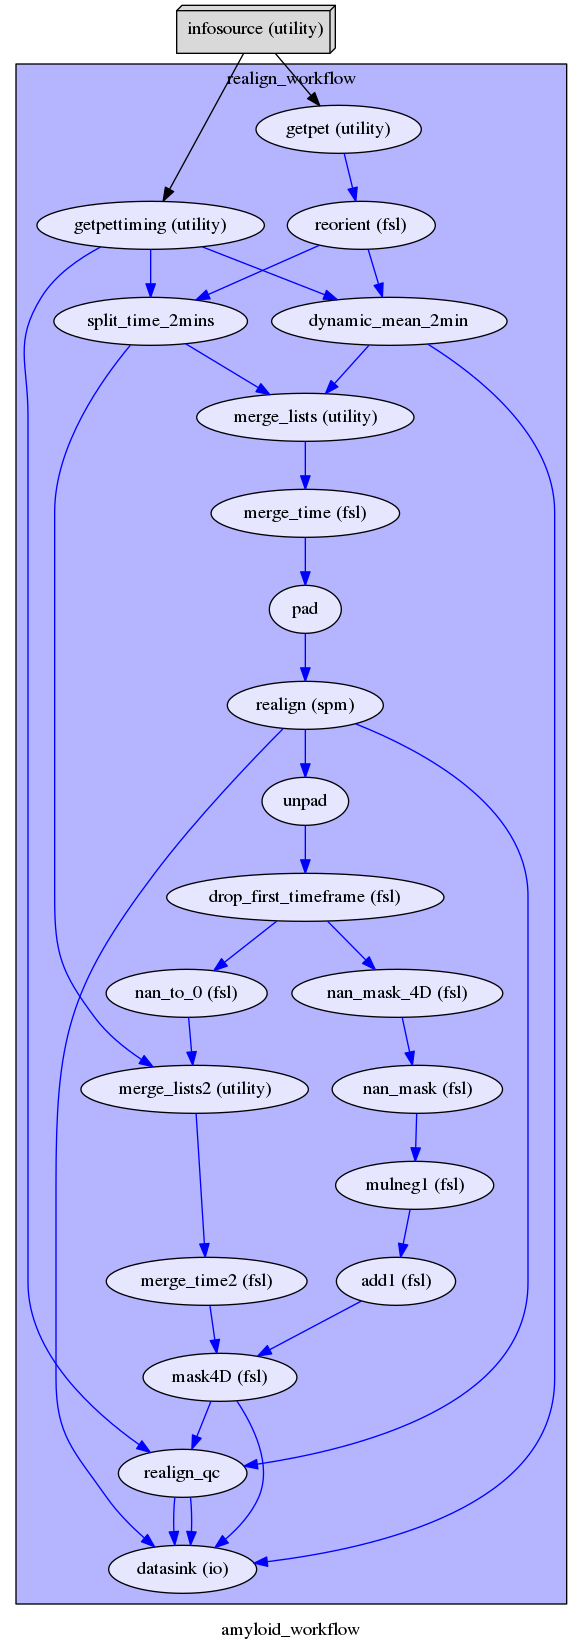

In [10]:
amyloid_workflow = Workflow(name="amyloid_workflow")
amyloid_workflow.base_dir = output_dir
amyloid_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'amyloid_crashdumps')}}
amyloid_workflow.connect([# PET time frame realignment
                      (infosource, realign_workflow, [('id','getpet.key'),
                                                      ('id','getpettiming.key')])
                    ])

amyloid_workflow.write_graph('realign.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'amyloid_workflow','realign.dot.png'))

In [11]:
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:19:55,459 workflow DEBUG:
	 MultiProcPlugin starting 20 threads in pool
170811-11:19:55,562 workflow DEBUG:
	 Creating flat graph for workflow: amyloid_workflow
170811-11:19:55,578 workflow DEBUG:
	 expanding workflow: amyloid_workflow
170811-11:19:55,582 workflow DEBUG:
	 processing node: amyloid_workflow.infosource
170811-11:19:55,583 workflow DEBUG:
	 processing node: amyloid_workflow.realign_workflow
170811-11:19:55,584 workflow DEBUG:
	 in: connections-> [('id', 'getpet.key'), ('id', 'getpettiming.key')]
170811-11:19:55,585 workflow DEBUG:
	 in: ('id', 'getpet.key')
170811-11:19:55,598 workflow DEBUG:
	 in edges: amyloid_workflow.infosource id realign_workflow.getpet key
170811-11:19:55,599 workflow DEBUG:
	 disconnect(): amyloid_workflow.infosource->amyloid_workflow.realign_workflow [('id', 'getpet.key')]
170811-11:19:55,600 workflow DEBUG:
	 disconnect(): remove list [('id', 'getpet.key')]
170811-11:19:55,601 workflow DEBUG:
	 disconnect(): removed connection ('id', 'g

### 2.1 REALIGN QUALITY CONTROL

Using the `datasink` in the realignment workflow, we saved copies of the main outputs of interest into a subdirectory named `output/realign_wf`. Using this output, we perform some quality control and visual checks of the results. First, we read in the frame timing csv file for this scan and extract frame start and end times.

Next, we extract the translation and rotation parameters from SPM realignment, and plot them over time to make sure that there is no wild subject motion.

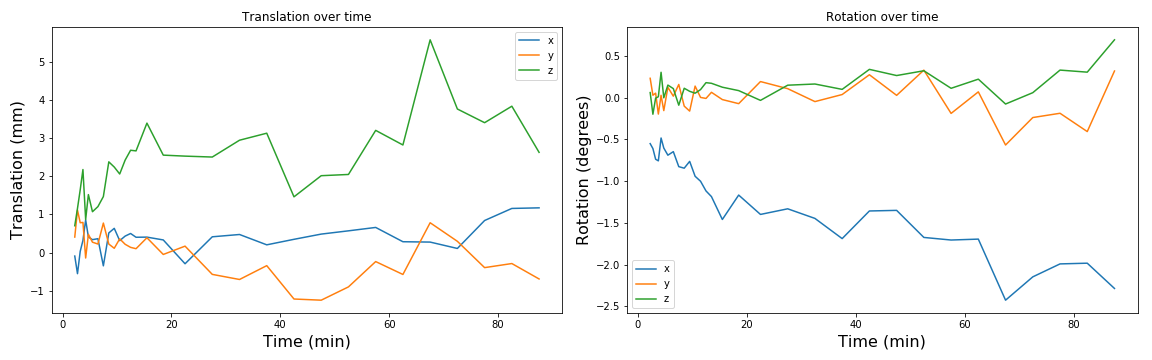

In [12]:
Image(filename=os.path.join(output_dir,'output','realign_wf','QC',id_example,'rp_'+id_example+'_pib_avg2min_plot.png'))

Finally, we visualize time frames of the realigned scan.

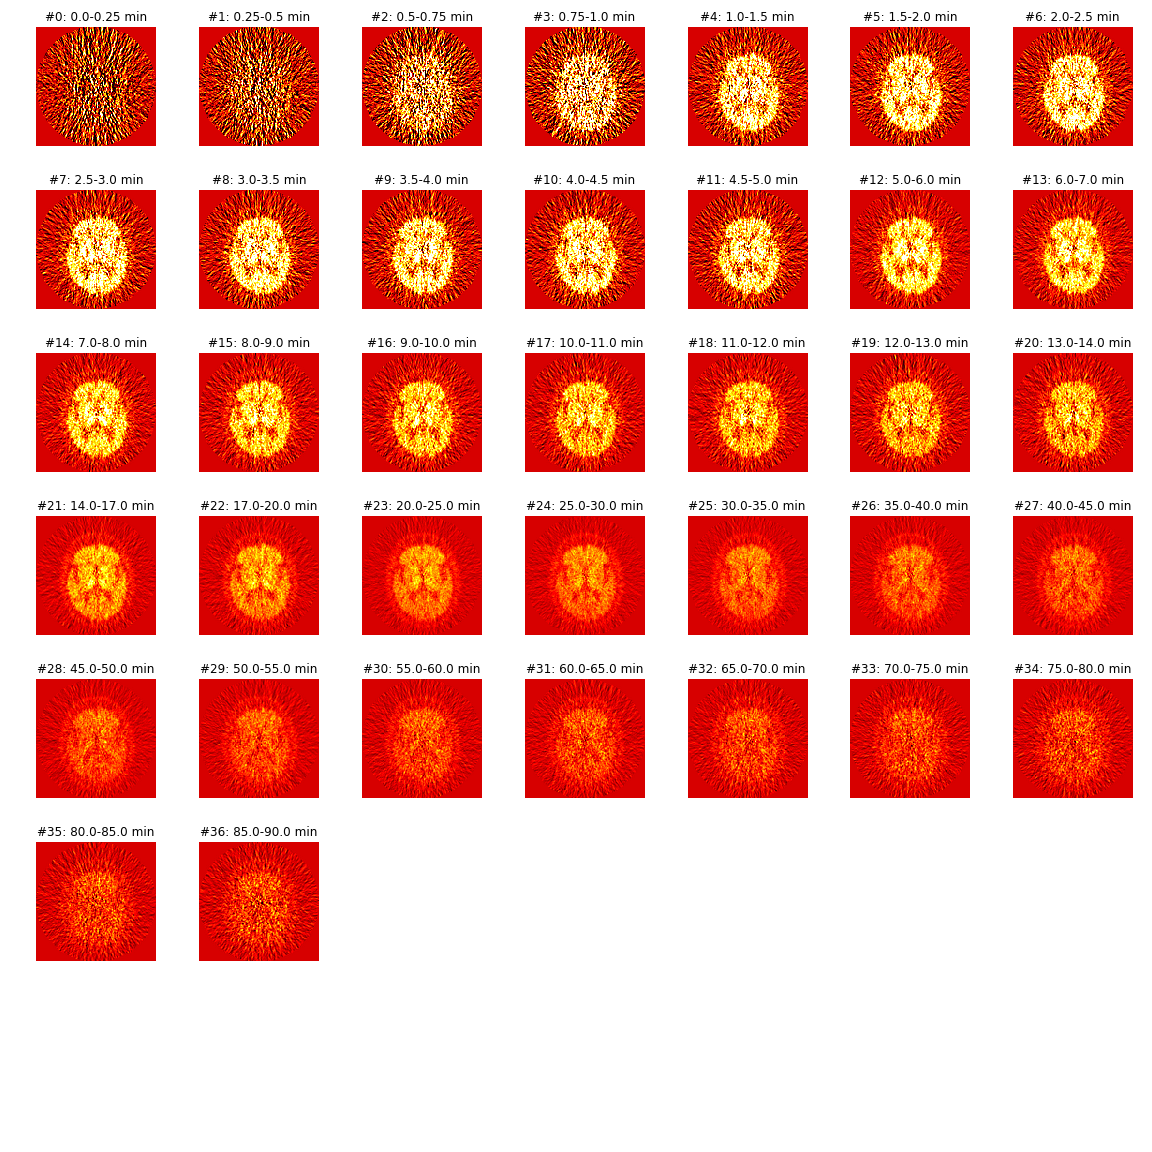

In [13]:
Image(filename=os.path.join(output_dir,'output','realign_wf','QC',id_example,id_example+'_pib_snap.png'))

## 3. MRI-PET COREGISTRATION

Our goal is to perform image processing in native PET space to produce parametric images. We have chosen this approach (rather than processing in native MRI space) for two reasons:
1. This approach avoids the use of PET data interpolated to match the voxel size of the MRI scans for generating parametric images. Such an interpolation is undesirable because of the large difference between PET and MRI voxel sizes.
2. Fewer brain voxels in native PET space allows for faster computation of voxelwise kinetic parameters for the whole brain.

It should be noted that PET space processing is not without disadvantages. Anatomical labels have to be interpolated to match the PET voxel size, which yields inaccuracies. While these inaccuracies are not important for reference region or ROI definitions for computing averages, they are influential for partial volume correction.

We have structural MRIs that have already been preprocessed and anatomically labeled. To bring anatomical labels to PET space, we will perform coregistration of the PET and the MRI.

* `dynamic_mean_20min`: We compute the average of amyloid time frames $<20$ mins, which will be used in the coregistration.
* `reorientmri` and `reorientlabel`:  Apply 90, 180, or 270 degree rotations as needed about the $x,y,z$ axes to match the MNI152 orientation.
* `pet_to_mri`: We use the image with finer spatial resolution (MRI) as the reference, and the amyloid PET 20-min average as the moving image, to perform rigid alignment with normalized mutual information cost function, using FSL's FLIRT method.
* `invertTransform`: Since we want anatomical labels in PET space, we invert the rigid transformation.
* `mri_to_pet` and `labels_to_pet`: We apply the inverted transformation to the MRI and anatomical labels to bring them to PET space.

_Note:_ For acquisitions that do not allow for the computation of a 20-min average image, we use the mean of the entire acquisition to perform coregistration with the MRI.

170811-11:19:57,907 workflow DEBUG:
	 (coreg_workflow.getmusemri, coreg_workflow.reorientmri): No edge data
170811-11:19:57,908 workflow DEBUG:
	 (coreg_workflow.getmusemri, coreg_workflow.reorientmri): new edge data: {'connect': [('musemri', 'in_file')]}
170811-11:19:57,909 workflow DEBUG:
	 (coreg_workflow.getmuselabel, coreg_workflow.reorientlabel): No edge data
170811-11:19:57,911 workflow DEBUG:
	 (coreg_workflow.getmuselabel, coreg_workflow.reorientlabel): new edge data: {'connect': [('muselabel', 'in_file')]}
170811-11:19:57,912 workflow DEBUG:
	 (coreg_workflow.realignedpet, coreg_workflow.dynamic_mean_20min): No edge data
170811-11:19:57,914 workflow DEBUG:
	 (coreg_workflow.realignedpet, coreg_workflow.dynamic_mean_20min): new edge data: {'connect': [('pet', 'timeSeriesImgFile')]}
170811-11:19:57,915 workflow DEBUG:
	 (coreg_workflow.dynamic_mean_20min, coreg_workflow.pet_to_mri): No edge data
170811-11:19:57,916 workflow DEBUG:
	 (coreg_workflow.dynamic_mean_20min, coreg_wor

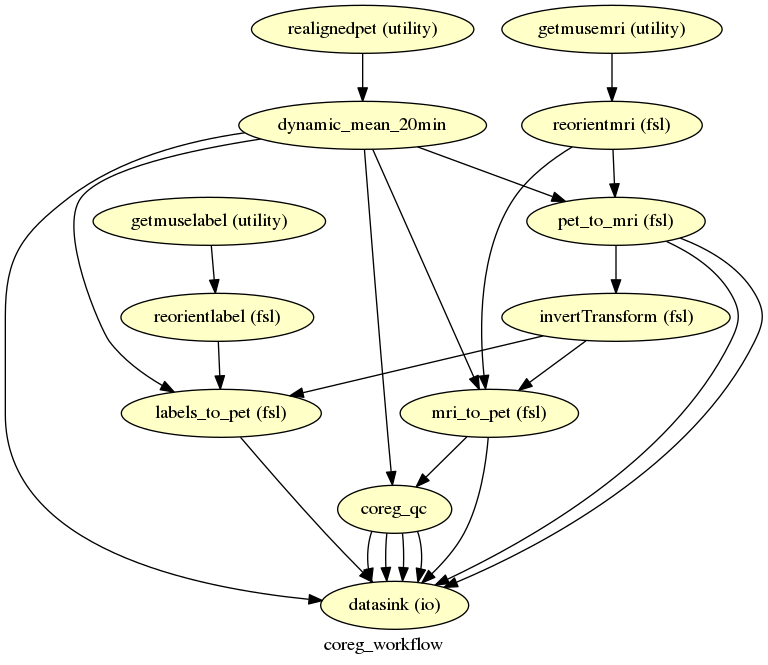

In [14]:
# a placeholder for the realigned 4D amyloid PET
realignedpet = Node(interface=IdentityInterface(fields=['pet']), name="realignedpet")

# Compute 0.75-20 min average that will be used for MRI coregistration
dynamic_mean_20min = Node(interface=DynamicMean(startTime=startTime_20min, endTime=endTime_20min),
                          name="dynamic_mean_20min")

# Reorient MRI and label
reorientmri = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorientmri")
reorientlabel = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorientlabel")

# MRI coregistration, rigid, with normalized mutual information
pet_to_mri = Node(interface=fsl.FLIRT(cost='normmi', dof=6, 
                                      searchr_x=[-30,30], searchr_y=[-30,30], searchr_z=[-30,30],
                                      coarse_search=15, fine_search=6), 
                  name="pet_to_mri")

invertTransform = Node(interface=fsl.ConvertXFM(invert_xfm=True), name="invertTransform")
mri_to_pet = Node(interface=fsl.ApplyXFM(apply_xfm=True), name="mri_to_pet")
labels_to_pet = Node(interface=fsl.ApplyXFM(apply_xfm=True, interp='nearestneighbour'), name="labels_to_pet")

coreg_qc = Node(interface=coreg_snapshots(), name="coreg_qc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','coreg_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg20min'),
                                 ('flirt','coreg'),
                                 ('_reoriented',''),
                                 ('_masked','')]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

coreg_workflow = Workflow(name="coreg_workflow")
coreg_workflow.base_dir = os.path.join(output_dir,'coreg_workingdir')
coreg_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'coreg_crashdumps')}}
coreg_workflow.connect([(getmusemri, reorientmri, [('musemri','in_file')]),
                        (getmuselabel, reorientlabel, [('muselabel','in_file')]),

                        (realignedpet, dynamic_mean_20min, [('pet','timeSeriesImgFile')]),

                        (dynamic_mean_20min, pet_to_mri, [('meanImgFile','in_file')]),
                        (reorientmri, pet_to_mri, [('out_file','reference')]),

                        (pet_to_mri, invertTransform, [('out_matrix_file','in_file')]),

                        (reorientmri, mri_to_pet, [('out_file','in_file')]),
                        (dynamic_mean_20min, mri_to_pet, [('meanImgFile','reference')]),
                        (invertTransform, mri_to_pet, [('out_file','in_matrix_file')]),

                        (reorientlabel, labels_to_pet, [('out_file','in_file')]),
                        (dynamic_mean_20min, labels_to_pet, [('meanImgFile','reference')]),
                        (invertTransform, labels_to_pet, [('out_file','in_matrix_file')]),

                        (dynamic_mean_20min, coreg_qc, [('meanImgFile','petavgfile')]),
                        (mri_to_pet, coreg_qc, [('out_file','mriregfile')]),

                        # save outputs
                        (dynamic_mean_20min, datasink, [('meanImgFile','avg20min')]), # 0.75-20min average (3D image) used for MRI coregistration
                        (pet_to_mri, datasink, [('out_file','coreg_avg20min'),
                                                ('out_matrix_file','coreg_avg20min.@param')]),
                        (mri_to_pet, datasink, [('out_file','coreg_mri')]), # MRI registered onto PET
                        (labels_to_pet, datasink, [('out_file','coreg_labels')]), # anatomical labels on PET
                        (coreg_qc, datasink, [('coreg_edges','QC'),
                                              ('coreg_overlay_sagittal','QC.@sag'),
                                              ('coreg_overlay_coronal','QC.@cor'),
                                              ('coreg_overlay_axial','QC.@ax')])
                       ])

coreg_workflow.write_graph('coreg.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'coreg_workingdir','coreg_workflow','coreg.dot.png'))

In [15]:
amyloid_workflow.connect([# PET-to-MRI registration
                      (infosource, coreg_workflow, [('id','getmusemri.key'),
                                                    ('id','getmuselabel.key')]),
                      (realign_workflow, coreg_workflow, [('mask4D.out_file','realignedpet.pet'),
                                                          ('getpettiming.pettiming','dynamic_mean_20min.frameTimingCsvFile')])
                     ])
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:19:59,141 workflow DEBUG:
	 (amyloid_workflow.infosource, amyloid_workflow.coreg_workflow): No edge data
170811-11:19:59,142 workflow DEBUG:
	 (amyloid_workflow.infosource, amyloid_workflow.coreg_workflow): new edge data: {'connect': [('id', 'getmusemri.key'), ('id', 'getmuselabel.key')]}
170811-11:19:59,144 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.coreg_workflow): No edge data
170811-11:19:59,145 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.coreg_workflow): new edge data: {'connect': [('mask4D.out_file', 'realignedpet.pet'), ('getpettiming.pettiming', 'dynamic_mean_20min.frameTimingCsvFile')]}
170811-11:19:59,147 workflow DEBUG:
	 MultiProcPlugin starting 20 threads in pool
170811-11:19:59,261 workflow DEBUG:
	 Creating flat graph for workflow: amyloid_workflow
170811-11:19:59,285 workflow DEBUG:
	 expanding workflow: amyloid_workflow
170811-11:19:59,286 workflow DEBUG:
	 processing node: amyloid_workflow.infosource
170

### 3.1 MRI-PET COREGISTRATION QUALITY CONTROL

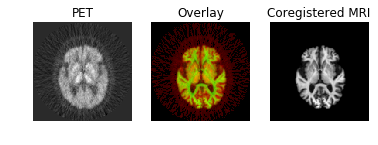

In [16]:
Image(filename=os.path.join(output_dir,'output','coreg_wf','QC',id_example,
                            id_example+'_pib_avg20min_coreg_overlay_axial.png'))

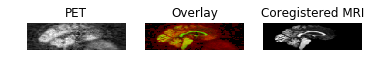

In [17]:
Image(filename=os.path.join(output_dir,'output','coreg_wf','QC',id_example,
                            id_example+'_pib_avg20min_coreg_overlay_sagittal.png'))

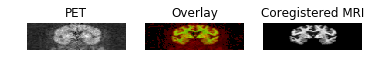

In [18]:
Image(filename=os.path.join(output_dir,'output','coreg_wf','QC',id_example,
                            id_example+'_pib_avg20min_coreg_overlay_coronal.png'))

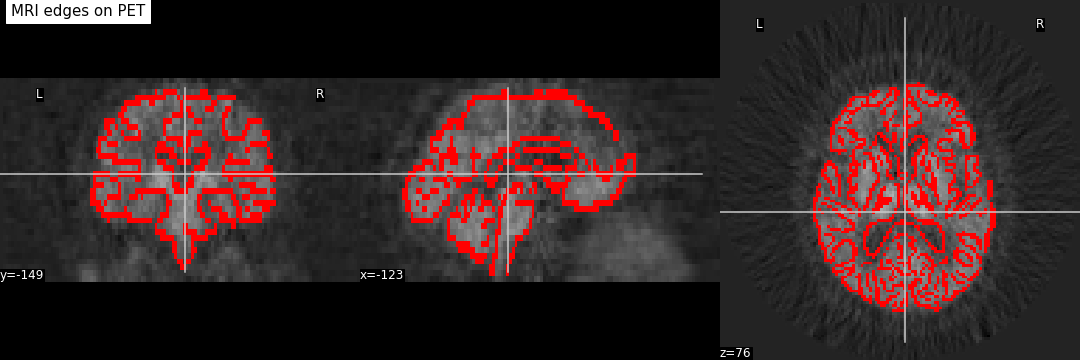

In [19]:
Image(filename=os.path.join(output_dir,'output','coreg_wf','QC',id_example,
                            id_example+'_pib_avg20min_coreg_edges.png'))

## 4. LABELS

We manipulate the anatomical label image to define the reference region for kinetic parameter computation, designate ROIs for partial volume correction, and determine composite ROIs for regional average reporting. Below, we define which MUSE label indices and their combinations form these three categories.

In [20]:
# ROI groupings for whole brain
whole_brain_ROI_grouping = {'whole brain':[23,30,36,37,55,56,57,58,75,76,59,60,
                            35,47,48,31,32,61,62,81,82,83,84,85,86,87,88,89,90,
                            91,92,93,94,95,104,105,136,137,146,147,178,179,
                            120,121,142,143,162,163,164,165,182,183,190,191,204,205,
                            124,125,140,141,150,151,152,153,186,187,192,193,
                            112,113,118,119,174,175,
                            106,107,176,177,194,195,198,199,148,149,168,169,
                            122,123,132,133,154,155,200,201,202,203,
                            180,181,184,185,206,207,
                            160,161,128,129,144,145,156,157,196,197,
                            108,109,114,115,134,135,116,117,170,171,
                            100,101,138,139,166,167,102,103,172,173,
                            40,41,38,39,71,72,73]}

# ROI groupings for reference region
reference_ROI_grouping = {'cerebellar GM':[38,39,71,72,73]}

# ROI groupings for PVC based on MUSE labels
pvc_ROI_groupings = {
    'background':[0],
    'ventricles and CSF':[-1,4,11,46,49,50,51,52], # includes non-WM-hypointensities. -1 is a label we will generate to approximate sulcal CSF
    'basal ganglia':[23,30,36,37,55,56,57,58,75,76], # striatum (caudate, putamen), pallidum, nucleus accumbens, substantia nigra, basal forebrain
    'thalamus':[59,60],
    'brainstem':[35], # combine with thalamus?
    'hippocampus':[47,48],
    'amygdala':[31,32],
    'cerebral WM':[61,62,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], # includes fornix, internal capsule, corpus callosum, ventral DC
    'inferior frontal GM':[104,105,136,137,146,147,178,179],
    'lateral frontal GM':[120,121,142,143,162,163,164,165,182,183,190,191,204,205],
    'medial frontal GM':[124,125,140,141,150,151,152,153,186,187,192,193],
    'opercular frontal GM':[112,113,118,119,174,175],
    'lateral parietal GM':[106,107,176,177,194,195,198,199],
    'medial parietal GM':[148,149,168,169],
    'inferior temporal GM':[122,123],
    'lateral temporal GM':[132,133,154,155,200,201,202,203],
    'supratemporal GM':[180,181,184,185,206,207],
    'inferior occipital GM':[160,161],
    'lateral occipital GM':[128,129,144,145,156,157,196,197],
    'medial occipital GM':[108,109,114,115,134,135],
    'limbic medial temporal GM':[116,117,170,171],
    'cingulate GM':[100,101,138,139,166,167],
    'insula GM':[102,103,172,173],
    'cerebellar WM':[40,41],
    'cerebellar GM':[38,39,71,72,73]
}

# sort by ROI name
pvc_ROI_groupings = OrderedDict(sorted(pvc_ROI_groupings.items(), key=lambda roi: roi[0]))

# ROIs for report spreadsheet
ROIs = {
    '3rd Ventricle':4,'4th Ventricle':11,'Right Accumbens Area':23,'Left Accumbens Area':30,
    'Right Amygdala':31,'Left Amygdala':32,'Brain Stem':35,'Right Caudate':36,'Left Caudate':37,
    'Right Cerebellum Exterior':38,'Left Cerebellum Exterior':39,
    'Right Cerebellum White Matter':40,'Left Cerebellum White Matter':41,
    'Right Hippocampus':47,'Left Hippocampus':48,'Right Inf Lat Vent':49,'Left Inf Lat Vent':50,
    'Right Lateral Ventricle':51,'Left Lateral Ventricle':52,'Right Pallidum':55,'Left Pallidum':56,
    'Right Putamen':57,'Left Putamen':58,'Right Thalamus Proper':59,'Left Thalamus Proper':60,
    'Right Ventral DC':61,'Left Ventral DC':62,
    'Cerebellar Vermal Lobules I-V':71,'Cerebellar Vermal Lobules VI-VII':72,'Cerebellar Vermal Lobules VIII-X':73,
    'Left Basal Forebrain':75,'Right Basal Forebrain':76,'frontal lobe WM right':81,'frontal lobe WM left':82,
    'occipital lobe WM right':83,'occipital lobe WM left':84,'parietal lobe WM right':85,'parietal lobe WM left':86,
    'temporal lobe WM right':87,'temporal lobe WM left':88,'fornix right':89,'fornix left':90,
    'anterior limb of internal capsule right':91,'anterior limb of internal capsule left':92,
    'posterior limb of internal capsule inc. cerebral peduncle right':93,
    'posterior limb of internal capsule inc. cerebral peduncle left':94,
    'corpus callosum':95,'Right ACgG  anterior cingulate gyrus':100,'Left ACgG  anterior cingulate gyrus':101,
    'Right AIns  anterior insula':102,'Left AIns  anterior insula':103,
    'Right AOrG  anterior orbital gyrus':104,'Left AOrG  anterior orbital gyrus':105,
    'Right AnG   angular gyrus':106,'Left AnG   angular gyrus':107,
    'Right Calc  calcarine cortex':108,'Left Calc  calcarine cortex':109,
    'Right CO    central operculum':112,'Left CO    central operculum':113,
    'Right Cun   cuneus':114,'Left Cun   cuneus':115,
    'Right Ent   entorhinal area':116,'Left Ent   entorhinal area':117,
    'Right FO    frontal operculum':118,'Left FO    frontal operculum':119,
    'Right FRP   frontal pole':120,'Left FRP   frontal pole':121,
    'Right FuG   fusiform gyrus':122,'Left FuG   fusiform gyrus':123,
    'Right GRe   gyrus rectus':124,'Left GRe   gyrus rectus':125,
    'Right IOG   inferior occipital gyrus':128,'Left IOG   inferior occipital gyrus':129,
    'Right ITG   inferior temporal gyrus':132,'Left ITG   inferior temporal gyrus':133,
    'Right LiG   lingual gyrus':134,'Left LiG   lingual gyrus':135,
    'Right LOrG  lateral orbital gyrus':136,'Left LOrG  lateral orbital gyrus':137,
    'Right MCgG  middle cingulate gyrus':138,'Left MCgG  middle cingulate gyrus':139,
    'Right MFC   medial frontal cortex':140,'Left MFC   medial frontal cortex':141,
    'Right MFG   middle frontal gyrus':142,'Left MFG   middle frontal gyrus':143,
    'Right MOG   middle occipital gyrus':144,'Left MOG   middle occipital gyrus':145,
    'Right MOrG  medial orbital gyrus':146,'Left MOrG  medial orbital gyrus':147,
    'Right MPoG  postcentral gyrus medial segment':148,'Left MPoG  postcentral gyrus medial segment':149,
    'Right MPrG  precentral gyrus medial segment':150,'Left MPrG  precentral gyrus medial segment':151,
    'Right MSFG  superior frontal gyrus medial segment':152,'Left MSFG  superior frontal gyrus medial segment':153,
    'Right MTG   middle temporal gyrus':154,'Left MTG   middle temporal gyrus':155,
    'Right OCP   occipital pole':156,'Left OCP   occipital pole':157,
    'Right OFuG  occipital fusiform gyrus':160,'Left OFuG  occipital fusiform gyrus':161,
    'Right OpIFG opercular part of the inferior frontal gyrus':162,
    'Left OpIFG opercular part of the inferior frontal gyrus':163,
    'Right OrIFG orbital part of the inferior frontal gyrus':164,
    'Left OrIFG orbital part of the inferior frontal gyrus':165,
    'Right PCgG  posterior cingulate gyrus':166,'Left PCgG  posterior cingulate gyrus':167,
    'Right PCu   precuneus':168,'Left PCu   precuneus':169,
    'Right PHG   parahippocampal gyrus':170,'Left PHG   parahippocampal gyrus':171,
    'Right PIns  posterior insula':172,'Left PIns  posterior insula':173,
    'Right PO    parietal operculum':174,'Left PO    parietal operculum':175,
    'Right PoG   postcentral gyrus':176,'Left PoG   postcentral gyrus':177,
    'Right POrG  posterior orbital gyrus':178,'Left POrG  posterior orbital gyrus':179,
    'Right PP    planum polare':180,'Left PP    planum polare':181,
    'Right PrG   precentral gyrus':182,'Left PrG   precentral gyrus':183,
    'Right PT    planum temporale':184,'Left PT    planum temporale':185,
    'Right SCA   subcallosal area':186,'Left SCA   subcallosal area':187,
    'Right SFG   superior frontal gyrus':190,'Left SFG   superior frontal gyrus':191,
    'Right SMC   supplementary motor cortex':192,'Left SMC   supplementary motor cortex':193,
    'Right SMG   supramarginal gyrus':194,'Left SMG   supramarginal gyrus':195,
    'Right SOG   superior occipital gyrus':196,'Left SOG   superior occipital gyrus':197,
    'Right SPL   superior parietal lobule':198,'Left SPL   superior parietal lobule':199,
    'Right STG   superior temporal gyrus':200,'Left STG   superior temporal gyrus':201,
    'Right TMP   temporal pole':202,'Left TMP   temporal pole':203,
    'Right TrIFG triangular part of the inferior frontal gyrus':204,
    'Left TrIFG triangular part of the inferior frontal gyrus':205,
    'Right TTG   transverse temporal gyrus':206,'Left TTG   transverse temporal gyrus':207
}

# sort by ROI name
ROIs = OrderedDict(sorted(ROIs.items(), key=lambda roi: roi[0]))

# Composite ROIs for report spreadsheet
compositeROIs = dict(pvc_ROI_groupings,
                     **{'precuneus':[168,169],
                        'mean cortical':[100,101,104,105,106,107,112,113,118,119,120,121,124,125,
                                         128,129,132,136,137,138,139,140,141,142,143,144,145,146,147,
                                         152,153,154,155,156,157,162,163,164,165,166,167,168,169,
                                         174,175,178,179,180,181,184,185,186,187,190,191,192,193,
                                         194,195,196,197,198,199,200,201,202,203,204,205,206,207]})

# sanity check -- make sure there's no overlap across groups of labels
pvc_all_labels = [label for group in list(pvc_ROI_groupings.values()) for label in group]
assert(len(pvc_all_labels)==len(set(pvc_all_labels)))

There are two streams of processing we will pursue. First, we generate a conservative reference region definition:
* `reference_region`: Combines the selected MUSE labels to generate a binary mask.
* `erode`: To minimize partial voluming effects, we slightly erode the reference region mask using a $5\times5\times5$ mm box kernel.

Second, we generate the set of labels that will be used in partial volume correction. MUSE labels do not include a sulcal CSF label, but this is an important label for PVC. We approximate the sulcal CSF label as the rim around the brain. To this end, we dilate the brain mask, and subtract from it the original brain mask. We designate a label value of $-1$ to this rim, and include it with the ventricle and CSF ROI for PVC.
* `brainmask`: Threshold the MUSE label image to get a binary brain mask.
* `dilate`: Dilate the brain mask using a $5\times5\times5$ mm box kernel.
* `difference`: Subtract dilated brain mask from the orginal mask to get the rim around the brain. This subtraction assigns a value of $-1$ to the rim.
* `add`: We add the rim image to the MUSE label image. Since the MUSE label image has value $0$ where the rim image has non-zero values, the result is a label image that preserves all the MUSE labels and additionally has a "sulcal CSF" label with value $-1$.
* `pvc_labels`: We combine the ROIs to generate a collection of binary masks. The result is a 4D volume (with all the binary 3D masks concatenated along 4th dimension). This 4D volume will be an input to the PVC methods.

170811-11:20:02,831 workflow DEBUG:
	 (labels_workflow.muselabel_unmasked, labels_workflow.muselabel): No edge data
170811-11:20:02,833 workflow DEBUG:
	 (labels_workflow.muselabel_unmasked, labels_workflow.muselabel): new edge data: {'connect': [('muselabel_unmasked', 'in_file')]}
170811-11:20:02,834 workflow DEBUG:
	 (labels_workflow.realign_mask, labels_workflow.muselabel): No edge data
170811-11:20:02,836 workflow DEBUG:
	 (labels_workflow.realign_mask, labels_workflow.muselabel): new edge data: {'connect': [('realign_mask', 'in_file2')]}
170811-11:20:02,837 workflow DEBUG:
	 (labels_workflow.muselabel, labels_workflow.reference_region): No edge data
170811-11:20:02,839 workflow DEBUG:
	 (labels_workflow.muselabel, labels_workflow.reference_region): new edge data: {'connect': [('out_file', 'labelImgFile')]}
170811-11:20:02,840 workflow DEBUG:
	 (labels_workflow.muselabel, labels_workflow.whole_brain): No edge data
170811-11:20:02,841 workflow DEBUG:
	 (labels_workflow.muselabel, la

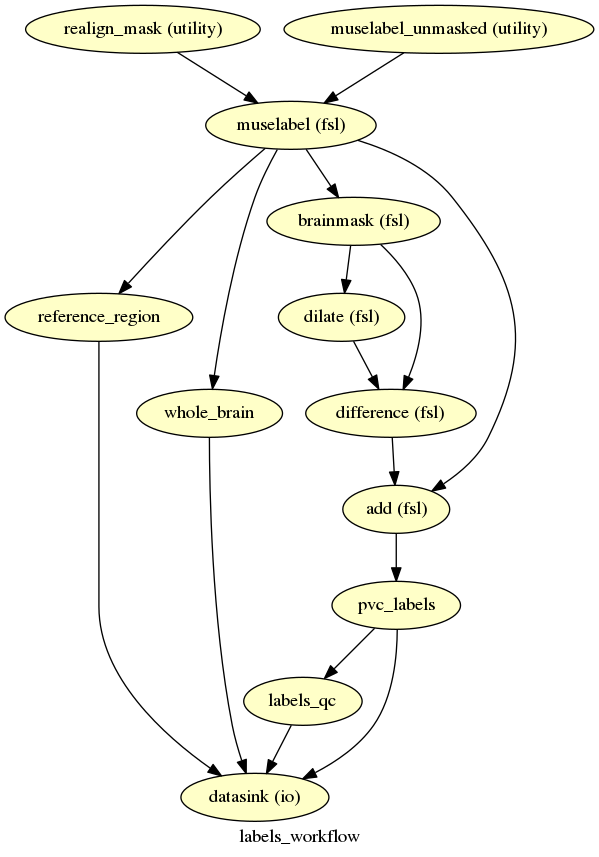

In [21]:
# placeholder
#muselabel = Node(interface=IdentityInterface(fields=['muselabel']), name="muselabel")
muselabel_unmasked = Node(interface=IdentityInterface(fields=['muselabel_unmasked']), name="muselabel_unmasked")
realign_mask = Node(interface=IdentityInterface(fields=['realign_mask']), name="realign_mask")

muselabel = Node(interface=fsl.ImageMaths(op_string=' -mas ', suffix="_masked"), name="muselabel")

reference_region = Node(interface=CombineROIs(ROI_groupings=list(reference_ROI_grouping.values())),
                        name="reference_region")
whole_brain = Node(interface=CombineROIs(ROI_groupings=list(whole_brain_ROI_grouping.values())),
                   name="whole_brain")

brainmask = Node(interface=fsl.ImageMaths(op_string=' -bin', suffix='_brainmask'), name='brainmask')
dilate = Node(interface=fsl.DilateImage(operation='max', kernel_shape='box', kernel_size=4), name='dilate')
difference = Node(interface=fsl.ImageMaths(op_string=' -sub ', suffix='_diff'), name='difference')
add = Node(interface=fsl.ImageMaths(op_string=' -add ', suffix='_add'), name='add')
pvc_labels = Node(interface=CombineROIs(ROI_groupings=list(pvc_ROI_groupings.values())), name="pvc_labels")

labels_qc = Node(interface=labels_snapshots(labelnames=list(pvc_ROI_groupings.keys())), name="labels_qc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','labels_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('flirt','coreg'),
                                 ('_'+'{:d}'.format(len(reference_ROI_grouping))+'combinedROIs','_refRegion'),
                                 ('_'+'{:d}'.format(len(pvc_ROI_groupings))+'combinedROIs','_pvcLabels'),
                                 ('_add',''),
                                 ('_masked','')
                                ]

labels_workflow = Workflow(name="labels_workflow")
labels_workflow.base_dir = os.path.join(output_dir,'labels_workingdir')
labels_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'labels_crashdumps')}}
labels_workflow.connect([(muselabel_unmasked, muselabel, [('muselabel_unmasked','in_file')]),
                         (realign_mask, muselabel, [('realign_mask','in_file2')]),

                         #(muselabel, reference_region, [('muselabel', 'labelImgFile')]),
                         #(muselabel, whole_brain, [('muselabel', 'labelImgFile')]),
                         (muselabel, reference_region, [('out_file', 'labelImgFile')]),
                         (muselabel, whole_brain, [('out_file', 'labelImgFile')]),

                         # Assign a value of -1 to voxels surrounding the brain
                         # this is an approximation for sulcal CSF label
                         #(muselabel, brainmask, [('muselabel','in_file')]),
                         (muselabel, brainmask, [('out_file','in_file')]),
                         (brainmask, dilate, [('out_file','in_file')]),
                         (brainmask, difference, [('out_file','in_file')]),
                         (dilate, difference, [('out_file','in_file2')]),
                         #(muselabel, add, [('muselabel','in_file')]),
                         (muselabel, add, [('out_file','in_file')]),
                         (difference, add,[('out_file','in_file2')]),
                         (add, pvc_labels, [('out_file','labelImgFile')]),

                         (pvc_labels, labels_qc, [('roi4DMaskFile','labelfile')]),

                         (reference_region, datasink, [('roi4DMaskFile','reference_region')]),
                         (whole_brain, datasink, [('roi4DMaskFile','whole_brain')]),
                         (pvc_labels, datasink, [('roi4DMaskFile','pvc_labels')]),
                         (labels_qc, datasink, [('label_snap','QC')])
                        ])

labels_workflow.write_graph('labels.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'labels_workingdir','labels_workflow','labels.dot.png'))

In [22]:
refReg_qc = Node(interface=refReg_snapshots(), name="refReg_qc")

amyloid_workflow.connect([# Anatomical label manipulation
                      (realign_workflow, labels_workflow, [('add1.out_file','realign_mask.realign_mask')]),
                      #(coreg_workflow, labels_workflow, [('labels_to_pet.out_file','muselabel.muselabel')]),
                      (coreg_workflow, labels_workflow, [('labels_to_pet.out_file','muselabel_unmasked.muselabel_unmasked')]),

                      (labels_workflow, refReg_qc, [('reference_region.roi4DMaskFile','maskfile')]),
                      (realign_workflow, refReg_qc, [('mask4D.out_file','petrealignedfile'),
                                                     ('getpettiming.pettiming','frameTimingCsvFile')]),
                      (coreg_workflow, refReg_qc, [('dynamic_mean_20min.meanImgFile','petavgfile')]),
                      (refReg_qc, datasink, [('maskOverlay_axial','QC.@ax'),
                                             ('maskOverlay_coronal','QC.@cor'),
                                             ('maskOverlay_sagittal','QC.@sag'),
                                             ('mask_TAC','QC.@tac')])
                     ])
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:20:04,65 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.labels_workflow): No edge data
170811-11:20:04,66 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.labels_workflow): new edge data: {'connect': [('add1.out_file', 'realign_mask.realign_mask')]}
170811-11:20:04,68 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.labels_workflow): No edge data
170811-11:20:04,69 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.labels_workflow): new edge data: {'connect': [('labels_to_pet.out_file', 'muselabel_unmasked.muselabel_unmasked')]}
170811-11:20:04,70 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.refReg_qc): No edge data
170811-11:20:04,72 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.refReg_qc): new edge data: {'connect': [('reference_region.roi4DMaskFile', 'maskfile')]}
170811-11:20:04,73 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloi

### 4.1 LABELS QUALITY CONTROL

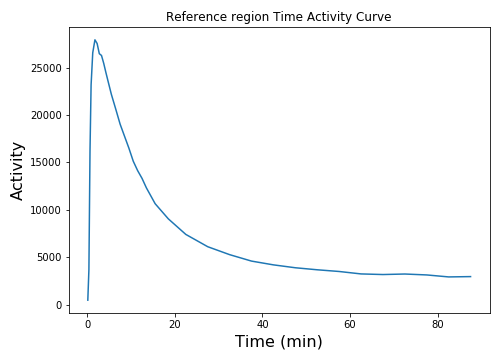

In [23]:
fname = glob(os.path.join(output_dir,'output','labels_wf','QC',id_example,
                            id_example+'_pib_reoriented_*'+'min_merged_mask_TAC.png'))
Image(filename=fname[0])

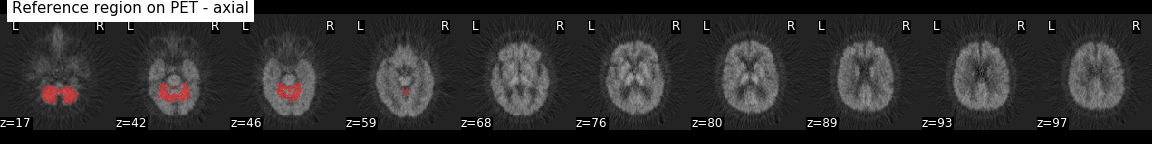

In [24]:
fname = glob(os.path.join(output_dir,'output','labels_wf','QC',id_example,
                            id_example+'_pib_reoriented_*'+'min_mean_maskOverlay_axial.png'))
Image(filename=fname[0])

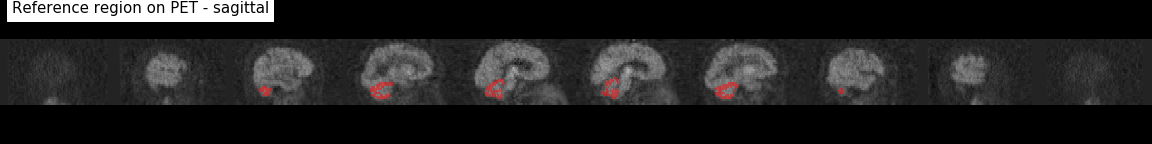

In [25]:
fname = glob(os.path.join(output_dir,'output','labels_wf','QC',id_example,
                            id_example+'_pib_reoriented_*'+'min_mean_maskOverlay_sagittal.png'))
Image(filename=fname[0])

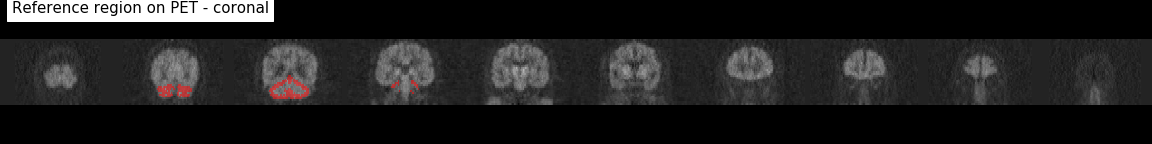

In [26]:
fname = glob(os.path.join(output_dir,'output','labels_wf','QC',id_example,
                            id_example+'_pib_reoriented_*'+'min_mean_maskOverlay_coronal.png'))
Image(filename=fname[0])

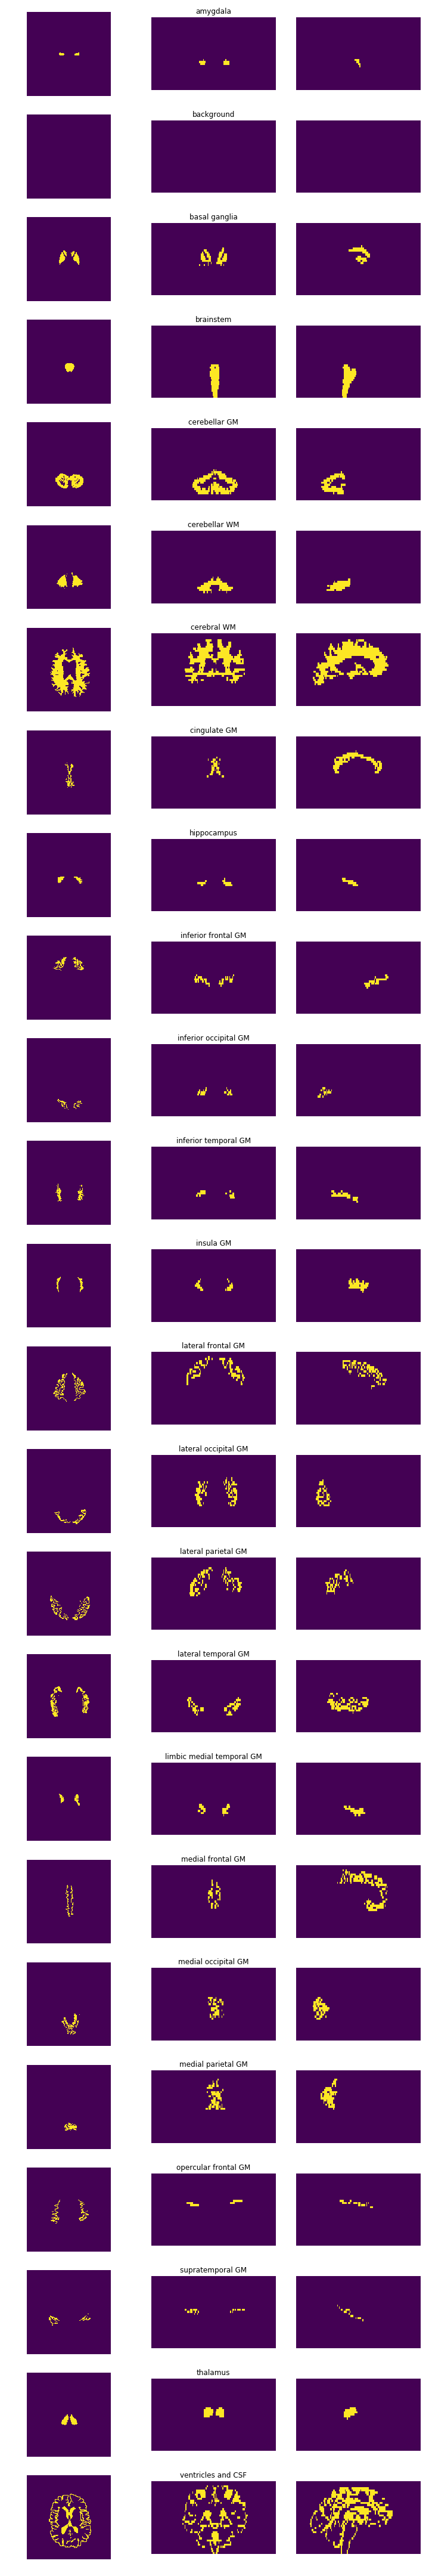

In [27]:
# PVC labels
fname = glob(os.path.join(output_dir,'output','labels_wf','QC',id_example,
                            id_example+'*_reoriented_coreg_pvcLabels_snap.png'))
Image(filename=fname[0])

## 5. PARTIAL VOLUME CORRECTION

170811-11:20:08,67 workflow DEBUG:
	 adding multipath trait: in_file
170811-11:20:08,72 workflow DEBUG:
	 (pvc_workflow.timesplit, pvc_workflow.pvc): No edge data
170811-11:20:08,74 workflow DEBUG:
	 (pvc_workflow.timesplit, pvc_workflow.pvc): new edge data: {'connect': [('out_files', 'in_file')]}
170811-11:20:08,75 workflow DEBUG:
	 (pvc_workflow.pvc, pvc_workflow.timemerge): No edge data
170811-11:20:08,77 workflow DEBUG:
	 (pvc_workflow.pvc, pvc_workflow.timemerge): new edge data: {'connect': [('out_file', 'in_files')]}
170811-11:20:08,78 workflow DEBUG:
	 (pvc_workflow.timemerge, pvc_workflow.datasink): No edge data
170811-11:20:08,79 workflow DEBUG:
	 (pvc_workflow.timemerge, pvc_workflow.datasink): new edge data: {'connect': [('merged_file', '@')]}
170811-11:20:08,81 workflow DEBUG:
	 connection: pvc_workflow_timesplit -> pvc_workflow_pvc;
170811-11:20:08,82 workflow DEBUG:
	 connection: pvc_workflow_pvc -> pvc_workflow_timemerge;
170811-11:20:08,83 workflow DEBUG:
	 connection: 

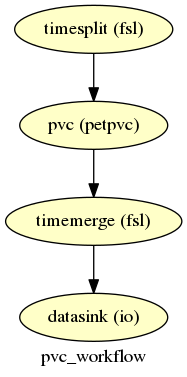

In [28]:
timesplit = Node(interface=fsl.Split(dimension='t'), name="timesplit")

pvc = MapNode(interface=petpvc.PETPVC(pvc='RBV', fwhm_x=pvc_fwhm_x, fwhm_y=pvc_fwhm_y, fwhm_z=pvc_fwhm_z),
              iterfield=['in_file'], name="pvc")

timemerge = Node(interface=fsl.Merge(dimension='t'), name="timemerge")


datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','PVC_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg20min'),
                                 ('flirt','coreg'),
                                 ('_reoriented',''),
                                 ('_add',''),
                                 ('_0000',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

pvc_workflow = Workflow(name="pvc_workflow")
pvc_workflow.base_dir = os.path.join(output_dir,'pvc_workingdir')
pvc_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'pvc_crashdumps')}}

pvc_workflow.connect([(timesplit, pvc, [('out_files','in_file')]),
                      (pvc, timemerge, [('out_file','in_files')]),

                      (timemerge, datasink, [('merged_file','@')])
                     ])

pvc_workflow.write_graph('pvc.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'pvc_workingdir','pvc_workflow','pvc.dot.png'))

In [29]:
amyloid_workflow.connect([(coreg_workflow, pvc_workflow, [(('realignedpet.pet',get_base_filename),'timesplit.out_base_name'),
                                                      ('realignedpet.pet', 'timesplit.in_file')]),
                      (labels_workflow, pvc_workflow, [('pvc_labels.roi4DMaskFile', 'pvc.mask_file')])
                     ])
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:20:09,204 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.pvc_workflow): No edge data
170811-11:20:09,205 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.pvc_workflow): new edge data: {'connect': [(('realignedpet.pet', "def get_base_filename(pth):\n    from nipype.utils.filemanip import split_filename\n    _, base, _ = split_filename(pth)\n    return base + '_'\n", ()), 'timesplit.out_base_name'), ('realignedpet.pet', 'timesplit.in_file')]}
170811-11:20:09,207 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.pvc_workflow): No edge data
170811-11:20:09,209 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.pvc_workflow): new edge data: {'connect': [('pvc_labels.roi4DMaskFile', 'pvc.mask_file')]}
170811-11:20:09,211 workflow DEBUG:
	 MultiProcPlugin starting 20 threads in pool
170811-11:20:09,328 workflow DEBUG:
	 Creating flat graph for workflow: amyloid_workflow
170811-11:20:09,363 workflow DEBU

## 6a. EARLY AMYLOID IMAGE

170811-11:20:14,412 workflow DEBUG:
	 Converted the join node ROImeans_ea field imgFileList trait type from a legal value to an existing file name
170811-11:20:14,414 workflow DEBUG:
	 Converted the join node ROImeans_ea field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:14,418 workflow DEBUG:
	 (EA_workflow.dynamic_mean_EA, EA_workflow.ROImean): No edge data
170811-11:20:14,420 workflow DEBUG:
	 (EA_workflow.dynamic_mean_EA, EA_workflow.ROImean): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:14,422 workflow DEBUG:
	 (EA_workflow.dynamic_mean_EA, EA_workflow.SUVR_EA): No edge data
170811-11:20:14,423 workflow DEBUG:
	 (EA_workflow.dynamic_mean_EA, EA_workflow.SUVR_EA): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:14,425 workflow DEBUG:
	 (EA_workflow.ROImean, EA_workflow.SUVR_EA): No edge data
170811-11:20:14,426 workflow DEBUG:
	 (EA_workflow.ROImean, EA_workflow.SUVR_EA): new edge data: {'connect

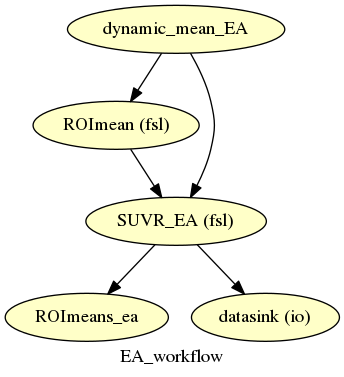

In [30]:
dynamic_mean_EA = Node(interface=DynamicMean(startTime=startTime_EA, endTime=endTime_EA), name="dynamic_mean_EA")

ROImean = Node(interface=fsl.ImageStats(op_string=' -k %s -m '), name="ROImean") # note that this is not a trimmed mean!
SUVR_EA = Node(interface=fsl.ImageMaths(), name="SUVR_EA")

ROImeans_ea = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'EA_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_ea")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','EA_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_reoriented',''),
                                 ('_mean','_EA'),
                                 ('_maths','_intensityNormalized'),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

EA_workflow = Workflow(name="EA_workflow")
EA_workflow.base_dir = os.path.join(output_dir,'EA_workingdir')
EA_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'EA_crashdumps')}}
EA_workflow.connect([(dynamic_mean_EA, ROImean, [('meanImgFile','in_file')]),
                     (dynamic_mean_EA, SUVR_EA, [('meanImgFile','in_file')]),
                     (ROImean, SUVR_EA, [(('out_stat',to_div_string),'op_string')]),

                     (SUVR_EA, ROImeans_ea, [('out_file','imgFileList')]),

                     (SUVR_EA, datasink, [('out_file','EA')])
                    ])

EA_workflow.write_graph('EA.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'EA_workingdir','EA_workflow','EA.dot.png'))

In [31]:
amyloid_workflow.connect([# Early amyloid image
                      (coreg_workflow, EA_workflow, [('realignedpet.pet', 'dynamic_mean_EA.timeSeriesImgFile')]),
                      (realign_workflow, EA_workflow, [('getpettiming.pettiming','dynamic_mean_EA.frameTimingCsvFile')]),
                      (labels_workflow, EA_workflow, [('muselabel.out_file','ROImeans_ea.labelImgFileList'),
                                                      ('whole_brain.roi4DMaskFile','ROImean.mask_file')]),
                     ])

170811-11:20:15,573 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.EA_workflow): No edge data
170811-11:20:15,575 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.EA_workflow): new edge data: {'connect': [('realignedpet.pet', 'dynamic_mean_EA.timeSeriesImgFile')]}
170811-11:20:15,576 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.EA_workflow): No edge data
170811-11:20:15,578 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.EA_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'dynamic_mean_EA.frameTimingCsvFile')]}
170811-11:20:15,579 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.EA_workflow): No edge data
170811-11:20:15,580 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.EA_workflow): new edge data: {'connect': [('muselabel.out_file', 'ROImeans_ea.labelImgFileList'), ('whole_brain.roi4DMaskFile', 'ROImean.mask_file')]}


## 6b. EARLY AMYLOID IMAGE WITH PVC

170811-11:20:15,654 workflow DEBUG:
	 Converted the join node ROImeans_ea_pvc field imgFileList trait type from a legal value to an existing file name
170811-11:20:15,656 workflow DEBUG:
	 Converted the join node ROImeans_ea_pvc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:15,660 workflow DEBUG:
	 (EA_pvc_workflow.dynamic_mean_EA_pvc, EA_pvc_workflow.ROImean): No edge data
170811-11:20:15,662 workflow DEBUG:
	 (EA_pvc_workflow.dynamic_mean_EA_pvc, EA_pvc_workflow.ROImean): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:15,663 workflow DEBUG:
	 (EA_pvc_workflow.dynamic_mean_EA_pvc, EA_pvc_workflow.SUVR_EA): No edge data
170811-11:20:15,665 workflow DEBUG:
	 (EA_pvc_workflow.dynamic_mean_EA_pvc, EA_pvc_workflow.SUVR_EA): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:15,666 workflow DEBUG:
	 (EA_pvc_workflow.ROImean, EA_pvc_workflow.SUVR_EA): No edge data
170811-11:20:15,667 workflow DEBUG:
	 (EA_

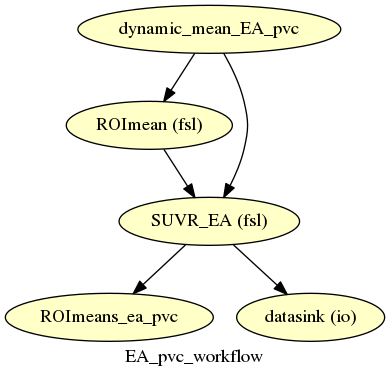

In [32]:
dynamic_mean_EA_pvc = Node(interface=DynamicMean(startTime=startTime_EA, endTime=endTime_EA), name="dynamic_mean_EA_pvc")

ROImean = Node(interface=fsl.ImageStats(op_string=' -k %s -m '), name="ROImean") # note that this is not a trimmed mean!
SUVR_EA = Node(interface=fsl.ImageMaths(), name="SUVR_EA")

ROImeans_ea_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'EA_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_ea_pvc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','EA_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_reoriented',''),
                                 ('_mean','_EA'),
                                 ('_maths','_intensityNormalized'),
                                 ('_0000',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

EA_pvc_workflow = Workflow(name="EA_pvc_workflow")
EA_pvc_workflow.base_dir = os.path.join(output_dir,'EA_workingdir')
EA_pvc_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'EA_crashdumps')}}
EA_pvc_workflow.connect([(dynamic_mean_EA_pvc, ROImean, [('meanImgFile','in_file')]),
                         (dynamic_mean_EA_pvc, SUVR_EA, [('meanImgFile','in_file')]),
                         (ROImean, SUVR_EA, [(('out_stat',to_div_string),'op_string')]),
                         (SUVR_EA, ROImeans_ea_pvc, [('out_file','imgFileList')]),

                         (SUVR_EA, datasink, [('out_file','EA_pvc')]),
                        ])

EA_pvc_workflow.write_graph('EA_pvc.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'EA_workingdir','EA_pvc_workflow','EA_pvc.dot.png'))

In [33]:
amyloid_workflow.connect([# Early amyloid image with PVC
                      (pvc_workflow, EA_pvc_workflow, [('timemerge.merged_file', 'dynamic_mean_EA_pvc.timeSeriesImgFile')]),
                      (realign_workflow, EA_pvc_workflow, [('getpettiming.pettiming','dynamic_mean_EA_pvc.frameTimingCsvFile')]),
                      (labels_workflow, EA_pvc_workflow, [('muselabel.out_file','ROImeans_ea_pvc.labelImgFileList'),
                                                          ('whole_brain.roi4DMaskFile','ROImean.mask_file')]),
                     ])

result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:20:16,797 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.EA_pvc_workflow): No edge data
170811-11:20:16,799 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.EA_pvc_workflow): new edge data: {'connect': [('timemerge.merged_file', 'dynamic_mean_EA_pvc.timeSeriesImgFile')]}
170811-11:20:16,801 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.EA_pvc_workflow): No edge data
170811-11:20:16,802 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.EA_pvc_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'dynamic_mean_EA_pvc.frameTimingCsvFile')]}
170811-11:20:16,804 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.EA_pvc_workflow): No edge data
170811-11:20:16,805 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.EA_pvc_workflow): new edge data: {'connect': [('muselabel.out_file', 'ROImeans_ea_pvc.labelImgFileList'), ('whole_brain.roi4DMaskFile', 'RO

(-0.5, 127.5, 34.5, -0.5)

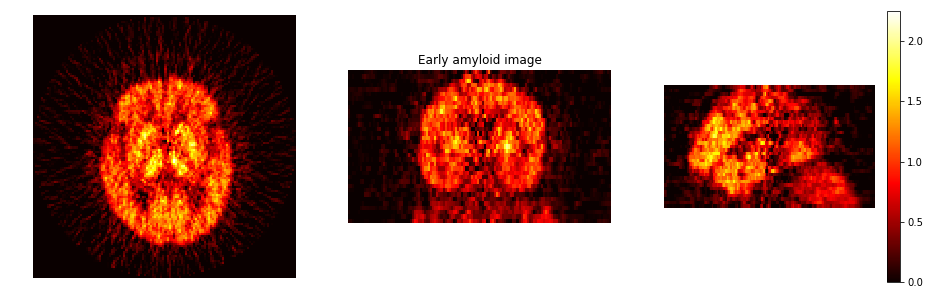

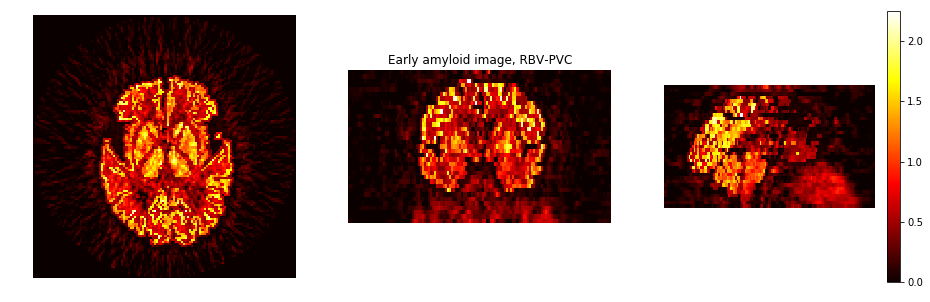

In [34]:
eafile = glob(os.path.join(output_dir,'output','EA_wf','EA',id_example,
                                     '*.nii*'))[0]
eapvcfile = glob(os.path.join(output_dir,'output','EA_wf','EA_pvc',id_example,
                                     '*.nii*'))[0]

ea = nib.load(eafile)
I = ea.get_data()
imdim = I.shape
voxsize = ea.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Early amyloid image')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


eapvc = nib.load(eapvcfile)
I = eapvc.get_data()
imdim = I.shape
voxsize = eapvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Early amyloid image, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 7a. SUVR IMAGE

170811-11:20:24,268 workflow DEBUG:
	 Converted the join node ROImeans field imgFileList trait type from a legal value to an existing file name
170811-11:20:24,269 workflow DEBUG:
	 Converted the join node ROImeans field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:24,273 workflow DEBUG:
	 (SUVR_workflow.dynamic_mean, SUVR_workflow.ROImean): No edge data
170811-11:20:24,275 workflow DEBUG:
	 (SUVR_workflow.dynamic_mean, SUVR_workflow.ROImean): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:24,276 workflow DEBUG:
	 (SUVR_workflow.dynamic_mean, SUVR_workflow.SUVR): No edge data
170811-11:20:24,278 workflow DEBUG:
	 (SUVR_workflow.dynamic_mean, SUVR_workflow.SUVR): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:24,279 workflow DEBUG:
	 (SUVR_workflow.ROImean, SUVR_workflow.SUVR): No edge data
170811-11:20:24,281 workflow DEBUG:
	 (SUVR_workflow.ROImean, SUVR_workflow.SUVR): new edge data: {'connect': [((

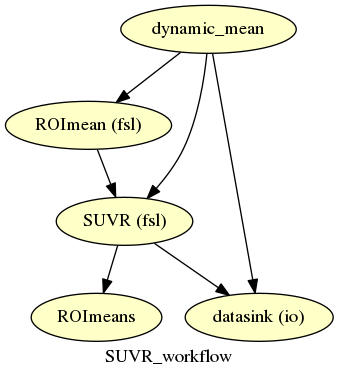

In [35]:
# Compute 40 to 60 min mean image for SUVR computation
dynamic_mean = Node(interface=DynamicMean(startTime=startTime_40to60min, endTime=endTime_40to60min),
                              name="dynamic_mean")

ROImean = Node(interface=fsl.ImageStats(op_string=' -k %s -m '), name="ROImean") # note that this is not a trimmed mean!
SUVR = Node(interface=fsl.ImageMaths(), name="SUVR")

ROImeans = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'SUVR_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','SUVR_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_mean','_avg40to60min'),
                                 ('_maths','_suvr'),
                                 ('_reoriented',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

SUVR_workflow = Workflow(name="SUVR_workflow")
SUVR_workflow.base_dir = os.path.join(output_dir,'SUVR_workingdir')
SUVR_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'SUVR_crashdumps')}}
SUVR_workflow.connect([(dynamic_mean, ROImean, [('meanImgFile','in_file')]),
                       (dynamic_mean, SUVR, [('meanImgFile','in_file')]),
                       (ROImean, SUVR, [(('out_stat',to_div_string),'op_string')]),
                       (SUVR, ROImeans, [('out_file','imgFileList')]),

                       (dynamic_mean, datasink, [('meanImgFile','avg40to60min')]),
                       (SUVR, datasink, [('out_file','SUVR_40to60min')])
                      ])

SUVR_workflow.write_graph('SUVR.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'SUVR_workingdir','SUVR_workflow','SUVR.dot.png'))

In [36]:
amyloid_workflow.connect([# SUVR computation
                      (coreg_workflow, SUVR_workflow, [('realignedpet.pet', 'dynamic_mean.timeSeriesImgFile')]),
                      (realign_workflow, SUVR_workflow, [('getpettiming.pettiming','dynamic_mean.frameTimingCsvFile')]),
                      (labels_workflow, SUVR_workflow, [('reference_region.roi4DMaskFile','ROImean.mask_file'),
                                                        ('muselabel.out_file','ROImeans.labelImgFileList')])
                     ])

170811-11:20:25,422 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.SUVR_workflow): No edge data
170811-11:20:25,424 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.SUVR_workflow): new edge data: {'connect': [('realignedpet.pet', 'dynamic_mean.timeSeriesImgFile')]}
170811-11:20:25,425 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.SUVR_workflow): No edge data
170811-11:20:25,427 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.SUVR_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'dynamic_mean.frameTimingCsvFile')]}
170811-11:20:25,428 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.SUVR_workflow): No edge data
170811-11:20:25,430 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.SUVR_workflow): new edge data: {'connect': [('reference_region.roi4DMaskFile', 'ROImean.mask_file'), ('muselabel.out_file', 'ROImeans.labelImgFileList')]}


## 7b. SUVR IMAGE WITH PVC

170811-11:20:25,508 workflow DEBUG:
	 Converted the join node ROImeans_pvc field imgFileList trait type from a legal value to an existing file name
170811-11:20:25,510 workflow DEBUG:
	 Converted the join node ROImeans_pvc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:25,514 workflow DEBUG:
	 (SUVR_pvc_workflow.dynamic_mean_pvc, SUVR_pvc_workflow.ROImean_pvc): No edge data
170811-11:20:25,516 workflow DEBUG:
	 (SUVR_pvc_workflow.dynamic_mean_pvc, SUVR_pvc_workflow.ROImean_pvc): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:25,517 workflow DEBUG:
	 (SUVR_pvc_workflow.dynamic_mean_pvc, SUVR_pvc_workflow.SUVR_pvc): No edge data
170811-11:20:25,519 workflow DEBUG:
	 (SUVR_pvc_workflow.dynamic_mean_pvc, SUVR_pvc_workflow.SUVR_pvc): new edge data: {'connect': [('meanImgFile', 'in_file')]}
170811-11:20:25,520 workflow DEBUG:
	 (SUVR_pvc_workflow.ROImean_pvc, SUVR_pvc_workflow.SUVR_pvc): No edge data
170811-11:20:25,522 workf

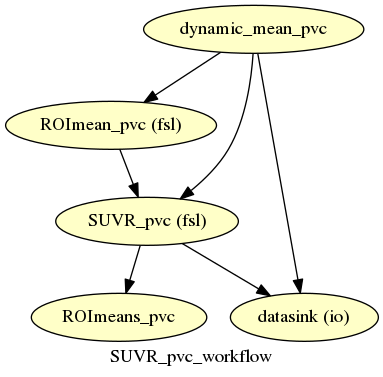

In [37]:
# Compute 40 to 60 min mean image for SUVR computation
dynamic_mean_pvc = Node(interface=DynamicMean(startTime=startTime_40to60min, endTime=endTime_40to60min),
                              name="dynamic_mean_pvc")

ROImean_pvc = Node(interface=fsl.ImageStats(op_string=' -k %s -m '), name="ROImean_pvc") # note that this is not a trimmed mean!
SUVR_pvc = Node(interface=fsl.ImageMaths(), name="SUVR_pvc")

ROImeans_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'SUVR_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_pvc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','SUVR_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_mean','_avg40to60min'),
                                 ('_maths','_suvr'),
                                 ('_reoriented',''),
                                 ('_0000',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

SUVR_pvc_workflow = Workflow(name="SUVR_pvc_workflow")
SUVR_pvc_workflow.base_dir = os.path.join(output_dir,'SUVR_workingdir')
SUVR_pvc_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'SUVR_crashdumps')}}
SUVR_pvc_workflow.connect([(dynamic_mean_pvc, ROImean_pvc, [('meanImgFile','in_file')]),
                       (dynamic_mean_pvc, SUVR_pvc, [('meanImgFile','in_file')]),
                       (ROImean_pvc, SUVR_pvc, [(('out_stat',to_div_string),'op_string')]),
                       (SUVR_pvc, ROImeans_pvc, [('out_file','imgFileList')]),

                       (dynamic_mean_pvc, datasink, [('meanImgFile','avg40to60min_pvc')]),
                       (SUVR_pvc, datasink, [('out_file','SUVR_40to60min_pvc')])
                      ])

SUVR_pvc_workflow.write_graph('SUVR_pvc.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'SUVR_workingdir','SUVR_pvc_workflow','SUVR_pvc.dot.png'))

In [38]:
amyloid_workflow.connect([# SUVR computation with PVC
                      (pvc_workflow, SUVR_pvc_workflow, [('timemerge.merged_file', 'dynamic_mean_pvc.timeSeriesImgFile')]),
                      (realign_workflow, SUVR_pvc_workflow, [('getpettiming.pettiming','dynamic_mean_pvc.frameTimingCsvFile')]),
                      (labels_workflow, SUVR_pvc_workflow, [('reference_region.roi4DMaskFile','ROImean_pvc.mask_file'),
                                                            ('muselabel.out_file','ROImeans_pvc.labelImgFileList')])
                     ])
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:20:26,680 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.SUVR_pvc_workflow): No edge data
170811-11:20:26,682 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.SUVR_pvc_workflow): new edge data: {'connect': [('timemerge.merged_file', 'dynamic_mean_pvc.timeSeriesImgFile')]}
170811-11:20:26,684 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.SUVR_pvc_workflow): No edge data
170811-11:20:26,685 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.SUVR_pvc_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'dynamic_mean_pvc.frameTimingCsvFile')]}
170811-11:20:26,687 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.SUVR_pvc_workflow): No edge data
170811-11:20:26,688 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.SUVR_pvc_workflow): new edge data: {'connect': [('reference_region.roi4DMaskFile', 'ROImean_pvc.mask_file'), ('muselabel.out_file', 'RO

(-0.5, 127.5, 34.5, -0.5)

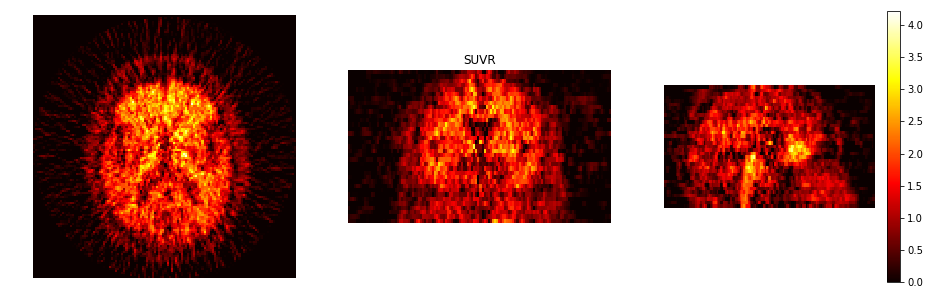

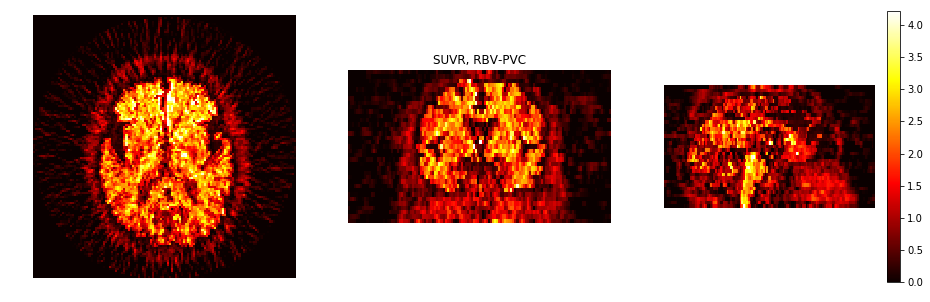

In [39]:
suvrfile = glob(os.path.join(output_dir,'output','SUVR_wf','SUVR',id_example,
                                     '*.nii*'))[0]
suvrpvcfile = glob(os.path.join(output_dir,'output','SUVR_wf','SUVR_pvc',id_example,
                                     '*.nii*'))[0]

suvr = nib.load(suvrfile)
I = suvr.get_data()
imdim = I.shape
voxsize = suvr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('SUVR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


suvrpvc = nib.load(suvrpvcfile)
I = suvrpvc.get_data()
imdim = I.shape
voxsize = suvrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('SUVR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 8a. DVR IMAGE

170811-11:20:51,750 workflow DEBUG:
	 Converted the join node ROImeans_dvr_wlr field imgFileList trait type from a legal value to an existing file name
170811-11:20:51,752 workflow DEBUG:
	 Converted the join node ROImeans_dvr_wlr field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:51,755 workflow DEBUG:
	 Converted the join node ROImeans_r1_wlr field imgFileList trait type from a legal value to an existing file name
170811-11:20:51,757 workflow DEBUG:
	 Converted the join node ROImeans_r1_wlr field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:51,760 workflow DEBUG:
	 Converted the join node ROImeans_dvr_lrsc field imgFileList trait type from a legal value to an existing file name
170811-11:20:51,762 workflow DEBUG:
	 Converted the join node ROImeans_dvr_lrsc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:51,765 workflow DEBUG:
	 Converted the join node ROImeans_r1

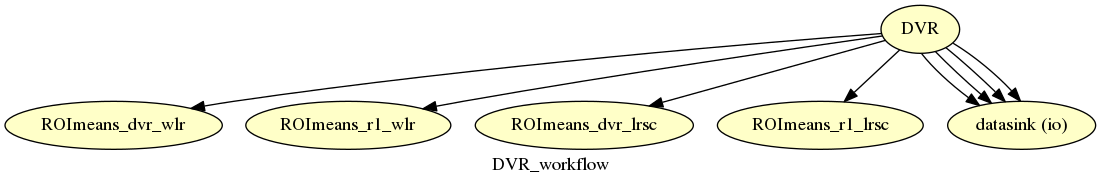

In [40]:
DVR = Node(interface=SRTM(startTime=startTime_DVR, endTime=endTime_DVR,
                          proportiontocut=proportiontocut, fwhm=smooth_fwhm), name="DVR")

ROImeans_dvr_wlr = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_wlr_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_wlr")

ROImeans_r1_wlr = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_wlr_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_wlr")

ROImeans_dvr_lrsc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_lrsc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_lrsc")

ROImeans_r1_lrsc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_lrsc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_lrsc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','DVR_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_reoriented',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r''),
                                        (r'_\d+\.\d+min',r'')]

DVR_workflow = Workflow(name="DVR_workflow")
DVR_workflow.base_dir = os.path.join(output_dir,'DVR_workingdir')
DVR_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'DVR_crashdumps')}}
DVR_workflow.connect([(DVR, ROImeans_dvr_wlr, [('DVRImgFile_wlr','imgFileList')]),
                      (DVR, ROImeans_r1_wlr, [('R1ImgFile_wlr','imgFileList')]),
                      (DVR, ROImeans_dvr_lrsc, [('DVRImgFile_lrsc','imgFileList')]),
                      (DVR, ROImeans_r1_lrsc, [('R1ImgFile_lrsc','imgFileList')]),

                      (DVR, datasink, [('DVRImgFile_wlr','wlr'),
                                       ('R1ImgFile_wlr','wlr.@R1'),
                                       ('DVRImgFile_lrsc','lrsc'),
                                       ('R1ImgFile_lrsc','lrsc.@R1')])
                     ])

DVR_workflow.write_graph('DVR.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'DVR_workingdir','DVR_workflow','DVR.dot.png'))

In [41]:
amyloid_workflow.connect([# DVR computation
                      (coreg_workflow, DVR_workflow, [('realignedpet.pet', 'DVR.timeSeriesImgFile')]),
                      (realign_workflow, DVR_workflow, [('getpettiming.pettiming','DVR.frameTimingCsvFile')]),
                      (labels_workflow, DVR_workflow, [('reference_region.roi4DMaskFile','DVR.refRegionMaskFile'),
                                                       ('muselabel.out_file','ROImeans_dvr_wlr.labelImgFileList'),
                                                       ('muselabel.out_file','ROImeans_r1_wlr.labelImgFileList'),
                                                       ('muselabel.out_file','ROImeans_dvr_lrsc.labelImgFileList'),
                                                       ('muselabel.out_file','ROImeans_r1_lrsc.labelImgFileList')])
                     ])

170811-11:20:55,362 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.DVR_workflow): No edge data
170811-11:20:55,364 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.DVR_workflow): new edge data: {'connect': [('realignedpet.pet', 'DVR.timeSeriesImgFile')]}
170811-11:20:55,365 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.DVR_workflow): No edge data
170811-11:20:55,367 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.DVR_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'DVR.frameTimingCsvFile')]}
170811-11:20:55,368 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.DVR_workflow): No edge data
170811-11:20:55,370 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.DVR_workflow): new edge data: {'connect': [('reference_region.roi4DMaskFile', 'DVR.refRegionMaskFile'), ('muselabel.out_file', 'ROImeans_dvr_wlr.labelImgFileList'), ('muselabel.out_file',

## 8b. DVR IMAGE WITH PVC

170811-11:20:58,584 workflow DEBUG:
	 Converted the join node ROImeans_dvr_wlr_pvc field imgFileList trait type from a legal value to an existing file name
170811-11:20:58,586 workflow DEBUG:
	 Converted the join node ROImeans_dvr_wlr_pvc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:58,589 workflow DEBUG:
	 Converted the join node ROImeans_r1_wlr_pvc field imgFileList trait type from a legal value to an existing file name
170811-11:20:58,591 workflow DEBUG:
	 Converted the join node ROImeans_r1_wlr_pvc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:58,594 workflow DEBUG:
	 Converted the join node ROImeans_dvr_lrsc_pvc field imgFileList trait type from a legal value to an existing file name
170811-11:20:58,596 workflow DEBUG:
	 Converted the join node ROImeans_dvr_lrsc_pvc field labelImgFileList trait type from a legal value to an existing file name
170811-11:20:58,599 workflow DEBUG:
	 Converted t

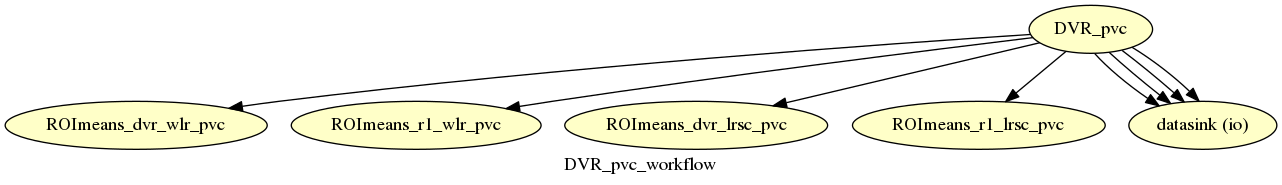

In [42]:
DVR_pvc = Node(interface=SRTM(startTime=startTime_DVR, endTime=endTime_DVR,
                          proportiontocut=proportiontocut, fwhm=smooth_fwhm), name="DVR_pvc")

ROImeans_dvr_wlr_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_wlr_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_wlr_pvc")

ROImeans_r1_wlr_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_wlr_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_wlr_pvc")

ROImeans_dvr_lrsc_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_lrsc_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_lrsc_pvc")

ROImeans_r1_lrsc_pvc = JoinNode(interface=ROI_stats_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_lrsc_pvc_ROI.xlsx'),
                                             stat='mean',
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_lrsc_pvc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','DVR_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_reoriented',''),
                                 ('_0000',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r''),
                                        (r'_\d+\.\d+min',r'')]

DVR_pvc_workflow = Workflow(name="DVR_pvc_workflow")
DVR_pvc_workflow.base_dir = os.path.join(output_dir,'DVR_workingdir')
DVR_pvc_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'DVR_crashdumps')}}
DVR_pvc_workflow.connect([(DVR_pvc, ROImeans_dvr_wlr_pvc, [('DVRImgFile_wlr','imgFileList')]),
                          (DVR_pvc, ROImeans_r1_wlr_pvc, [('R1ImgFile_wlr','imgFileList')]),
                          (DVR_pvc, ROImeans_dvr_lrsc_pvc, [('DVRImgFile_lrsc','imgFileList')]),
                          (DVR_pvc, ROImeans_r1_lrsc_pvc, [('R1ImgFile_lrsc','imgFileList')]),

                          (DVR_pvc, datasink, [('DVRImgFile_wlr','wlr_pvc'),
                                               ('R1ImgFile_wlr','wlr_pvc.@R1'),
                                               ('DVRImgFile_lrsc','lrsc_pvc'),
                                               ('R1ImgFile_lrsc','lrsc_pvc.@R1')])
                         ])

DVR_pvc_workflow.write_graph('DVR_pvc.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'DVR_workingdir','DVR_pvc_workflow','DVR_pvc.dot.png'))

In [43]:
amyloid_workflow.connect([# DVR computation with PVC
                      (pvc_workflow, DVR_pvc_workflow, [('timemerge.merged_file', 'DVR_pvc.timeSeriesImgFile')]),
                      (realign_workflow, DVR_pvc_workflow, [('getpettiming.pettiming','DVR_pvc.frameTimingCsvFile')]),
                      (labels_workflow, DVR_pvc_workflow, [('reference_region.roi4DMaskFile','DVR_pvc.refRegionMaskFile'),
                                                           ('muselabel.out_file','ROImeans_dvr_wlr_pvc.labelImgFileList'),
                                                           ('muselabel.out_file','ROImeans_r1_wlr_pvc.labelImgFileList'),
                                                           ('muselabel.out_file','ROImeans_dvr_lrsc_pvc.labelImgFileList'),
                                                           ('muselabel.out_file','ROImeans_r1_lrsc_pvc.labelImgFileList')])
                     ])

result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:21:01,644 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.DVR_pvc_workflow): No edge data
170811-11:21:01,645 workflow DEBUG:
	 (amyloid_workflow.pvc_workflow, amyloid_workflow.DVR_pvc_workflow): new edge data: {'connect': [('timemerge.merged_file', 'DVR_pvc.timeSeriesImgFile')]}
170811-11:21:01,647 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.DVR_pvc_workflow): No edge data
170811-11:21:01,648 workflow DEBUG:
	 (amyloid_workflow.realign_workflow, amyloid_workflow.DVR_pvc_workflow): new edge data: {'connect': [('getpettiming.pettiming', 'DVR_pvc.frameTimingCsvFile')]}
170811-11:21:01,650 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.DVR_pvc_workflow): No edge data
170811-11:21:01,651 workflow DEBUG:
	 (amyloid_workflow.labels_workflow, amyloid_workflow.DVR_pvc_workflow): new edge data: {'connect': [('reference_region.roi4DMaskFile', 'DVR_pvc.refRegionMaskFile'), ('muselabel.out_file', 'ROImeans_dvr_wlr_pvc.l

(-0.5, 127.5, 34.5, -0.5)

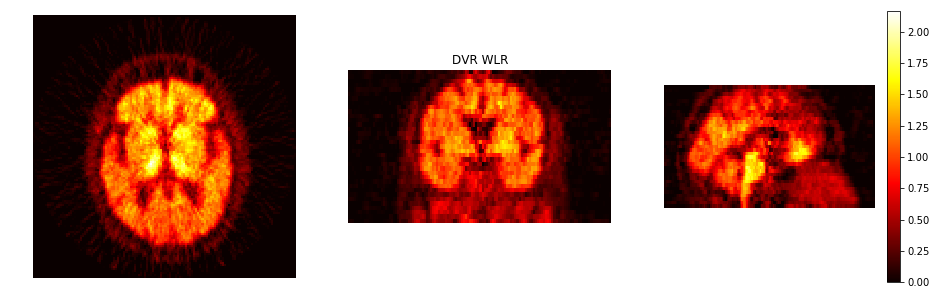

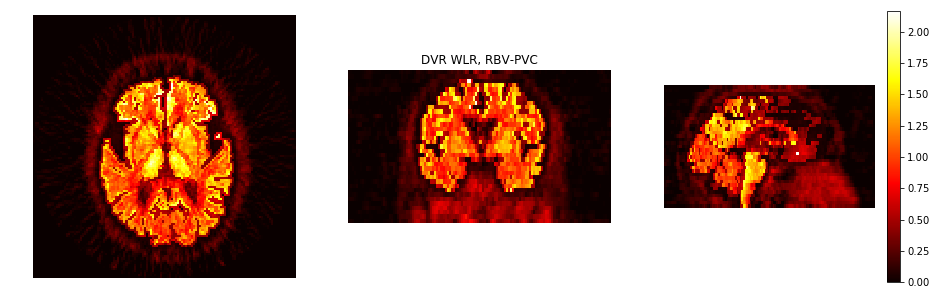

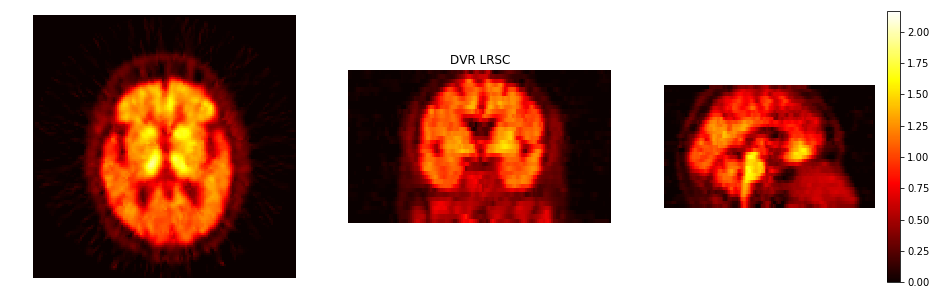

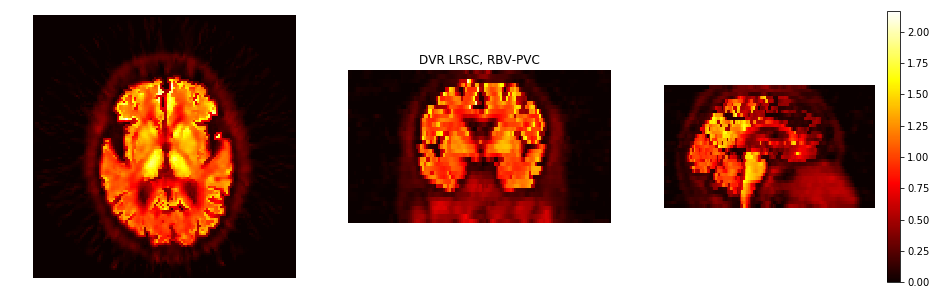

In [44]:
dvrwlrfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr',id_example,
                                     '*DVR*.nii*'))[0]
dvrwlrpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr_pvc',id_example,
                                     '*DVR*.nii*'))[0]
dvrlrscfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc',id_example,
                                     '*DVR*.nii*'))[0]
dvrlrscpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc_pvc',id_example,
                                     '*DVR*.nii*'))[0]

dvrwlr = nib.load(dvrwlrfile)
I = dvrwlr.get_data()
imdim = I.shape
voxsize = dvrwlr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR WLR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrwlrpvc = nib.load(dvrwlrpvcfile)
I = dvrwlrpvc.get_data()
imdim = I.shape
voxsize = dvrwlrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR WLR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrlrsc = nib.load(dvrlrscfile)
I = dvrlrsc.get_data()
imdim = I.shape
voxsize = dvrlrsc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR LRSC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrlrscpvc = nib.load(dvrlrscpvcfile)
I = dvrlrscpvc.get_data()
imdim = I.shape
voxsize = dvrlrscpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR LRSC, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

(-0.5, 127.5, 34.5, -0.5)

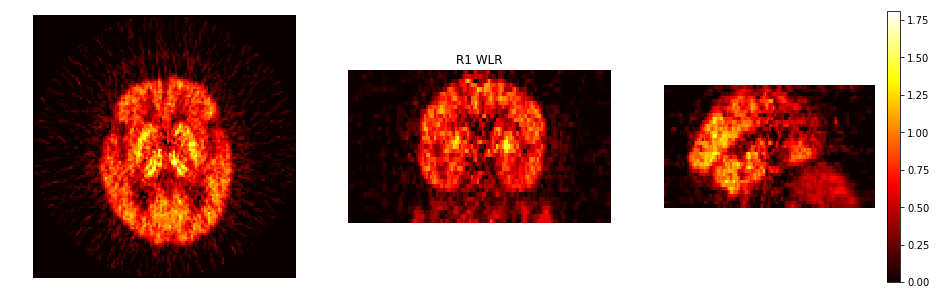

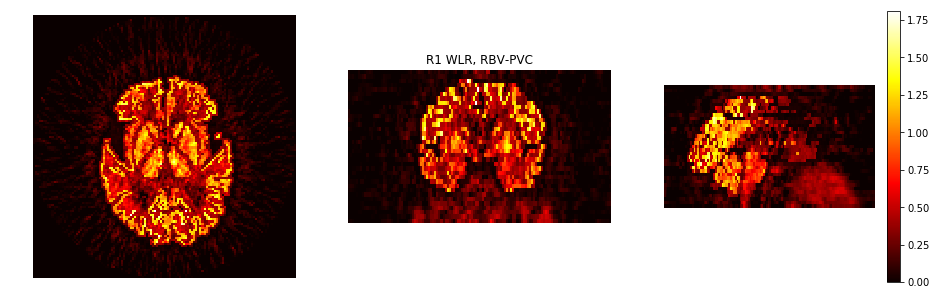

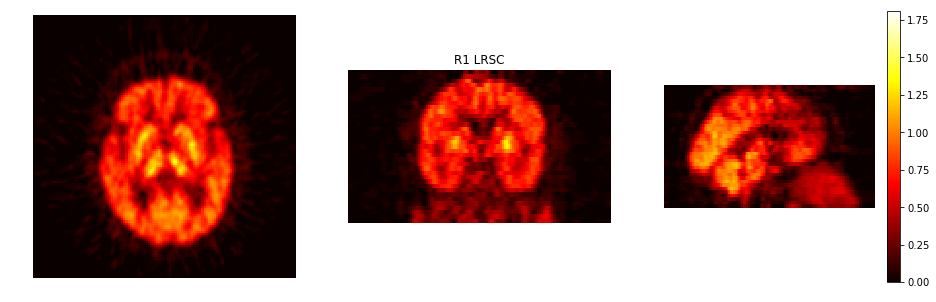

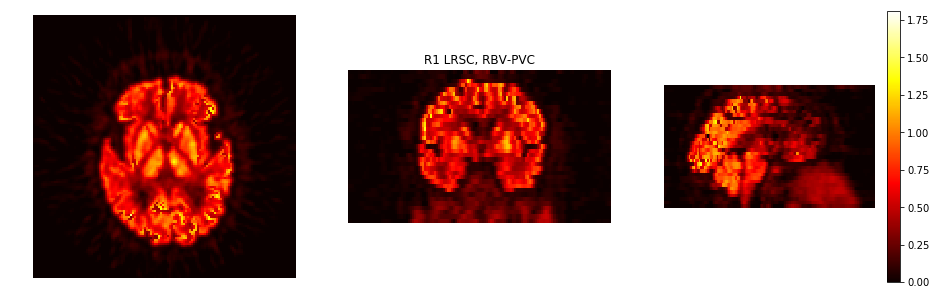

In [45]:
r1wlrfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr',id_example,
                                     '*R1*.nii*'))[0]
r1wlrpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr_pvc',id_example,
                                     '*R1*.nii*'))[0]
r1lrscfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc',id_example,
                                     '*R1*.nii*'))[0]
r1lrscpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc_pvc',id_example,
                                     '*R1*.nii*'))[0]

r1wlr = nib.load(r1wlrfile)
I = r1wlr.get_data()
imdim = I.shape
voxsize = r1wlr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 WLR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1wlrpvc = nib.load(r1wlrpvcfile)
I = r1wlrpvc.get_data()
imdim = I.shape
voxsize = r1wlrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 WLR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1lrsc = nib.load(r1lrscfile)
I = r1lrsc.get_data()
imdim = I.shape
voxsize = r1lrsc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 LRSC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1lrscpvc = nib.load(r1lrscpvcfile)
I = r1lrscpvc.get_data()
imdim = I.shape
voxsize = r1lrscpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 LRSC, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 9. MNI SPACE

170811-11:32:39,140 workflow DEBUG:
	 (MNI_workflow.mri, MNI_workflow.mri_to_mni): No edge data
170811-11:32:39,142 workflow DEBUG:
	 (MNI_workflow.mri, MNI_workflow.mri_to_mni): new edge data: {'connect': [('mri', 'in_file')]}
170811-11:32:39,144 workflow DEBUG:
	 (MNI_workflow.mri_to_mni, MNI_workflow.mergexfm): No edge data
170811-11:32:39,145 workflow DEBUG:
	 (MNI_workflow.mri_to_mni, MNI_workflow.mergexfm): new edge data: {'connect': [('out_matrix_file', 'in_file2')]}
170811-11:32:39,146 workflow DEBUG:
	 (MNI_workflow.pet20min, MNI_workflow.warp_pet): No edge data
170811-11:32:39,148 workflow DEBUG:
	 (MNI_workflow.pet20min, MNI_workflow.warp_pet): new edge data: {'connect': [('pet20min', 'in_file')]}
170811-11:32:39,149 workflow DEBUG:
	 (MNI_workflow.mergexfm, MNI_workflow.warp_pet): No edge data
170811-11:32:39,151 workflow DEBUG:
	 (MNI_workflow.mergexfm, MNI_workflow.warp_pet): new edge data: {'connect': [('out_file', 'in_matrix_file')]}
170811-11:32:39,152 workflow DEBUG:


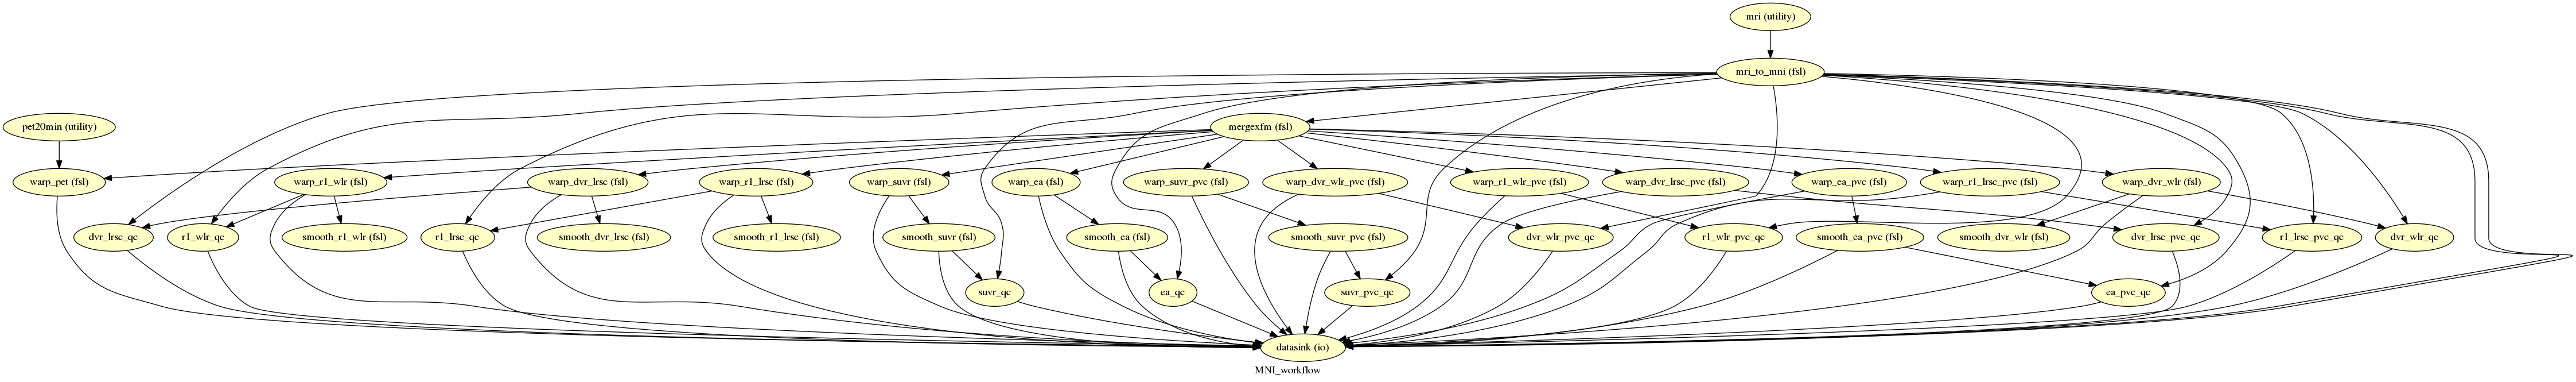

In [46]:
template = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

# placeholders
mri = Node(interface=IdentityInterface(fields=['mri']), name="mri")
pet20min = Node(interface=IdentityInterface(fields=['pet20min']), name="pet20min")

# Very quick registration to MNI template
mri_to_mni = Node(interface=fsl.FLIRT(dof=12,reference=template), name="mri_to_mni")

mergexfm = Node(interface=fsl.ConvertXFM(concat_xfm=True), name="mergexfm")

warp_pet = Node(interface=fsl.ApplyXFM(apply_xfm=True, reference=template), name='warp_pet')

warp_dvr_wlr = warp_pet.clone(name='warp_dvr_wlr')
warp_r1_wlr = warp_pet.clone(name='warp_r1_wlr')
warp_dvr_lrsc = warp_pet.clone(name='warp_dvr_lrsc')
warp_r1_lrsc = warp_pet.clone(name='warp_r1_lrsc')
warp_suvr = warp_pet.clone(name='warp_suvr')
warp_ea = warp_pet.clone(name='warp_ea')

warp_dvr_wlr_pvc = warp_pet.clone(name='warp_dvr_wlr_pvc')
warp_r1_wlr_pvc = warp_pet.clone(name='warp_r1_wlr_pvc')
warp_dvr_lrsc_pvc = warp_pet.clone(name='warp_dvr_lrsc_pvc')
warp_r1_lrsc_pvc = warp_pet.clone(name='warp_r1_lrsc_pvc')
warp_suvr_pvc = warp_pet.clone(name='warp_suvr_pvc')
warp_ea_pvc = warp_pet.clone(name='warp_ea_pvc')

# Gaussian smoothing
smooth_ea = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_ea")
smooth_ea_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_ea_pvc")

smooth_suvr = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_suvr")
smooth_suvr_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_suvr_pvc")

smooth_dvr_wlr = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_dvr_wlr")
smooth_dvr_lrsc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_dvr_lrsc")
smooth_r1_wlr = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_r1_wlr")
smooth_r1_lrsc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_r1_lrsc")

smooth_dvr_wlr_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_dvr_wlr_pvc")
smooth_dvr_lrsc_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_dvr_lrsc_pvc")
smooth_r1_wlr_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_r1_wlr_pvc")
smooth_r1_lrsc_pvc = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth_r1_lrsc_pvc")

# Triplanar snapshots
dvr_wlr_qc = Node(interface=triplanar_snapshots(alpha=.5, x=81, y=93, z=77, vmin=0.0, vmax=2.5), name="dvr_wlr_qc")
dvr_lrsc_qc = dvr_wlr_qc.clone(name="dvr_lrsc_qc")
dvr_wlr_pvc_qc = dvr_wlr_qc.clone(name="dvr_wlr_pvc_qc")
dvr_lrsc_pvc_qc = dvr_wlr_qc.clone(name="dvr_lrsc_pvc_qc")

r1_wlr_qc = Node(interface=triplanar_snapshots(alpha=.5, x=81, y=93, z=77, vmin=0.0, vmax=2.0), name="r1_wlr_qc")
r1_lrsc_qc = r1_wlr_qc.clone(name="r1_lrsc_qc")
r1_wlr_pvc_qc = r1_wlr_qc.clone(name="r1_wlr_pvc_qc")
r1_lrsc_pvc_qc = r1_wlr_qc.clone(name="r1_lrsc_pvc_qc")

suvr_qc = Node(interface=triplanar_snapshots(alpha=.5, x=81, y=93, z=77, vmin=0.0, vmax=4.0), name="suvr_qc")
suvr_pvc_qc = suvr_qc.clone(name="suvr_pvc_qc")
ea_qc = suvr_qc.clone(name="ea_qc")
ea_pvc_qc = suvr_qc.clone(name="ea_pvc_qc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','MNI_wf')
datasink.inputs.substitutions = [('_id_',''),
                                 ('_merged',''),
                                 ('_reoriented',''),
                                 ('_trans','_mni'),
                                 ('flirt','mni'),
                                 ('_0000',''),
                                 ('_masked','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r''),
                                        (r'_\d+\.\d+min',r'')]

MNI_workflow = Workflow(name="MNI_workflow")
MNI_workflow.base_dir = os.path.join(output_dir,'MNI_workingdir')
MNI_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'MNI_crashdumps')}}
MNI_workflow.connect([(mri, mri_to_mni, [('mri','in_file')]),

                      (mri_to_mni, mergexfm, [('out_matrix_file','in_file2')]),

                      (pet20min, warp_pet, [('pet20min','in_file')]),
                      (mergexfm, warp_pet, [('out_file', 'in_matrix_file')]),

                      (mergexfm, warp_dvr_wlr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_wlr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_dvr_lrsc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_lrsc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_suvr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_ea, [('out_file','in_matrix_file')]),

                      (mergexfm, warp_dvr_wlr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_wlr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_dvr_lrsc_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_lrsc_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_suvr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_ea_pvc, [('out_file','in_matrix_file')]),

                      (warp_dvr_wlr, smooth_dvr_wlr, [('out_file','in_file')]),
                      (warp_r1_wlr, smooth_r1_wlr, [('out_file','in_file')]),
                      (warp_dvr_lrsc, smooth_dvr_lrsc, [('out_file','in_file')]),
                      (warp_r1_lrsc, smooth_r1_lrsc, [('out_file','in_file')]),
                      (warp_suvr, smooth_suvr, [('out_file','in_file')]),
                      (warp_ea, smooth_ea, [('out_file','in_file')]),

                      (warp_suvr_pvc, smooth_suvr_pvc, [('out_file','in_file')]),
                      (warp_ea_pvc, smooth_ea_pvc, [('out_file','in_file')]),

                      (mri_to_mni, dvr_wlr_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, dvr_lrsc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, r1_wlr_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, r1_lrsc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, suvr_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, ea_qc, [('out_file','bgimgfile')]),

                      (mri_to_mni, dvr_wlr_pvc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, dvr_lrsc_pvc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, r1_wlr_pvc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, r1_lrsc_pvc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, suvr_pvc_qc, [('out_file','bgimgfile')]),
                      (mri_to_mni, ea_pvc_qc, [('out_file','bgimgfile')]),

                      (warp_dvr_wlr, dvr_wlr_qc, [('out_file','imgfile')]),
                      (warp_r1_wlr, r1_wlr_qc, [('out_file','imgfile')]),
                      (warp_dvr_lrsc, dvr_lrsc_qc, [('out_file','imgfile')]),
                      (warp_r1_lrsc, r1_lrsc_qc, [('out_file','imgfile')]),
                      (smooth_suvr, suvr_qc, [('smoothed_file','imgfile')]),
                      (smooth_ea, ea_qc, [('smoothed_file','imgfile')]),

                      (warp_dvr_wlr_pvc, dvr_wlr_pvc_qc, [('out_file','imgfile')]),
                      (warp_r1_wlr_pvc, r1_wlr_pvc_qc, [('out_file','imgfile')]),
                      (warp_dvr_lrsc_pvc, dvr_lrsc_pvc_qc, [('out_file','imgfile')]),
                      (warp_r1_lrsc_pvc, r1_lrsc_pvc_qc, [('out_file','imgfile')]),
                      (smooth_suvr_pvc, suvr_pvc_qc, [('smoothed_file','imgfile')]),
                      (smooth_ea_pvc, ea_pvc_qc, [('smoothed_file','imgfile')]),

                      (mri_to_mni, datasink, [('out_file','warped_mri'),
                                              ('out_matrix_file','warped_mri.@param')]),
                      (warp_pet, datasink, [('out_file','warped_pet')]),

                      (warp_dvr_wlr, datasink, [('out_file','warped_dvr_wlr')]),
                      (warp_r1_wlr, datasink, [('out_file','warped_r1_wlr')]),
                      (warp_dvr_lrsc, datasink, [('out_file','warped_dvr_lrsc')]),
                      (warp_r1_lrsc, datasink, [('out_file','warped_r1_lrsc')]),
                      (warp_suvr, datasink, [('out_file','warped_suvr')]),
                      (warp_ea, datasink, [('out_file','warped_ea')]),
                      (smooth_suvr, datasink, [('smoothed_file','warped_suvr.@smooth')]),
                      (smooth_ea, datasink, [('smoothed_file','warped_ea.@smooth')]),

                      (warp_dvr_wlr_pvc, datasink, [('out_file','warped_dvr_wlr_pvc')]),
                      (warp_r1_wlr_pvc, datasink, [('out_file','warped_r1_wlr_pvc')]),
                      (warp_dvr_lrsc_pvc, datasink, [('out_file','warped_dvr_lrsc_pvc')]),
                      (warp_r1_lrsc_pvc, datasink, [('out_file','warped_r1_lrsc_pvc')]),
                      (warp_suvr_pvc, datasink, [('out_file','warped_suvr_pvc')]),
                      (warp_ea_pvc, datasink, [('out_file','warped_ea_pvc')]),
                      (smooth_suvr_pvc, datasink, [('smoothed_file','warped_suvr_pvc.@smooth')]),
                      (smooth_ea_pvc, datasink, [('smoothed_file','warped_ea_pvc.@smooth')]),

                      (dvr_wlr_qc, datasink, [('triplanar','QC')]),
                      (dvr_lrsc_qc, datasink, [('triplanar','QC.@dvr_lrsc')]),
                      (r1_wlr_qc, datasink, [('triplanar','QC.@r1_wlr')]),
                      (r1_lrsc_qc, datasink, [('triplanar','QC.@r1_lrsc')]),
                      (suvr_qc, datasink, [('triplanar','QC@SUVR')]),
                      (ea_qc, datasink, [('triplanar','QC@EA')]),

                      (dvr_wlr_pvc_qc, datasink, [('triplanar','QC.@dvr_wlr_pvc')]),
                      (dvr_lrsc_pvc_qc, datasink, [('triplanar','QC.@dvr_lrsc_pvc')]),
                      (r1_wlr_pvc_qc, datasink, [('triplanar','QC.@r1_wlr_pvc')]),
                      (r1_lrsc_pvc_qc, datasink, [('triplanar','QC.@r1_lrsc_pvc')]),
                      (suvr_pvc_qc, datasink, [('triplanar','QC@SUVR_PVC')]),
                      (ea_pvc_qc, datasink, [('triplanar','QC@EA_PVC')]),
                     ])

MNI_workflow.write_graph('MNI.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'MNI_workingdir','MNI_workflow','MNI.dot.png'))

In [47]:
amyloid_workflow.connect([# MNI space normalization
                      (coreg_workflow, MNI_workflow, [('reorientmri.out_file','mri.mri'),
                                                      ('dynamic_mean_20min.meanImgFile','pet20min.pet20min'),
                                                      ('pet_to_mri.out_matrix_file','mergexfm.in_file')]),
                      (DVR_workflow, MNI_workflow, [('DVR.DVRImgFile_wlr','warp_dvr_wlr.in_file'),
                                                    ('DVR.R1ImgFile_wlr','warp_r1_wlr.in_file'),
                                                    ('DVR.DVRImgFile_lrsc','warp_dvr_lrsc.in_file'),
                                                    ('DVR.R1ImgFile_lrsc','warp_r1_lrsc.in_file')]),
                      (DVR_pvc_workflow, MNI_workflow, [('DVR_pvc.DVRImgFile_wlr','warp_dvr_wlr_pvc.in_file'),
                                                        ('DVR_pvc.R1ImgFile_wlr','warp_r1_wlr_pvc.in_file'),
                                                        ('DVR_pvc.DVRImgFile_lrsc','warp_dvr_lrsc_pvc.in_file'),
                                                        ('DVR_pvc.R1ImgFile_lrsc','warp_r1_lrsc_pvc.in_file')]),
                      (SUVR_workflow, MNI_workflow, [('SUVR.out_file','warp_suvr.in_file')]),
                      (SUVR_pvc_workflow, MNI_workflow, [('SUVR_pvc.out_file','warp_suvr_pvc.in_file')]),
                      (EA_workflow, MNI_workflow, [('SUVR_EA.out_file','warp_ea.in_file')]),
                      (EA_pvc_workflow, MNI_workflow, [('SUVR_EA.out_file','warp_ea_pvc.in_file')]),
                     ])
result = amyloid_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

170811-11:32:53,173 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.MNI_workflow): No edge data
170811-11:32:53,175 workflow DEBUG:
	 (amyloid_workflow.coreg_workflow, amyloid_workflow.MNI_workflow): new edge data: {'connect': [('reorientmri.out_file', 'mri.mri'), ('dynamic_mean_20min.meanImgFile', 'pet20min.pet20min'), ('pet_to_mri.out_matrix_file', 'mergexfm.in_file')]}
170811-11:32:53,177 workflow DEBUG:
	 (amyloid_workflow.DVR_workflow, amyloid_workflow.MNI_workflow): No edge data
170811-11:32:53,178 workflow DEBUG:
	 (amyloid_workflow.DVR_workflow, amyloid_workflow.MNI_workflow): new edge data: {'connect': [('DVR.DVRImgFile_wlr', 'warp_dvr_wlr.in_file'), ('DVR.R1ImgFile_wlr', 'warp_r1_wlr.in_file'), ('DVR.DVRImgFile_lrsc', 'warp_dvr_lrsc.in_file'), ('DVR.R1ImgFile_lrsc', 'warp_r1_lrsc.in_file')]}
170811-11:32:53,179 workflow DEBUG:
	 (amyloid_workflow.DVR_pvc_workflow, amyloid_workflow.MNI_workflow): No edge data
170811-11:32:53,181 workflow DEBUG:
	 (amyloid_

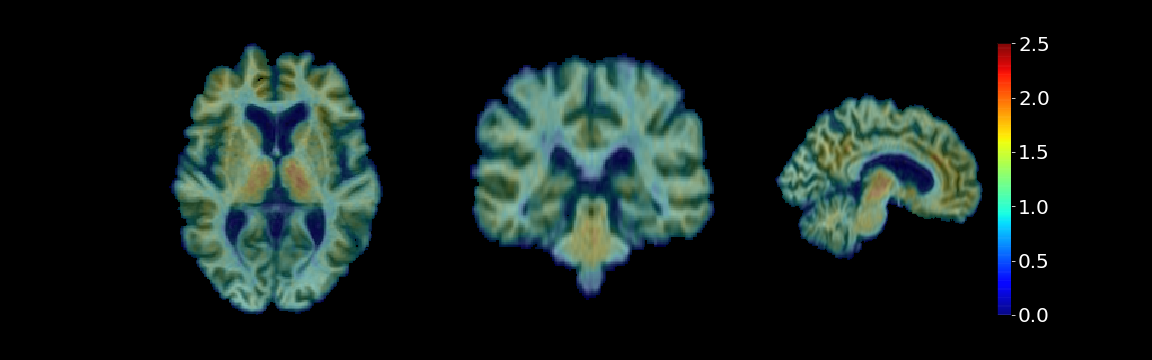

In [48]:
# DVR WLR
Image(filename=os.path.join(output_dir,'output','MNI_wf','QC',id_example,
                            id_example+'_pib_DVR_wlr_mni_snap.png'))

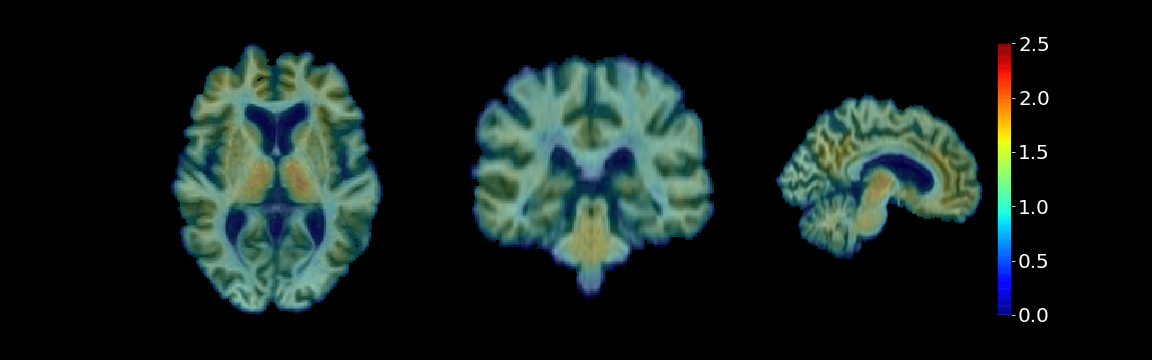

In [49]:
# DVR LRSC
Image(filename=os.path.join(output_dir,'output','MNI_wf','QC',id_example,
                            id_example+'_pib_DVR_lrsc_mni_snap.png'))

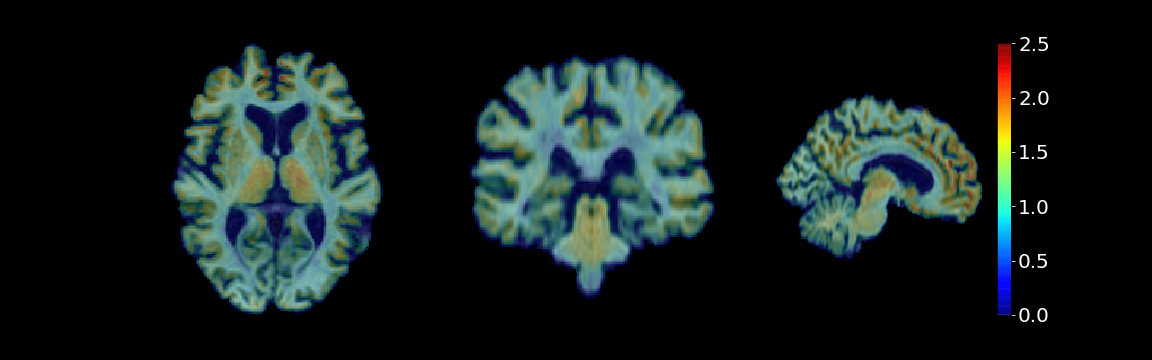

In [50]:
# DVR WLR (PVC)
Image(filename=os.path.join(output_dir,'output','MNI_wf','QC',id_example,
                            id_example+'_pib_rbv_pvc_DVR_wlr_mni_snap.png'))

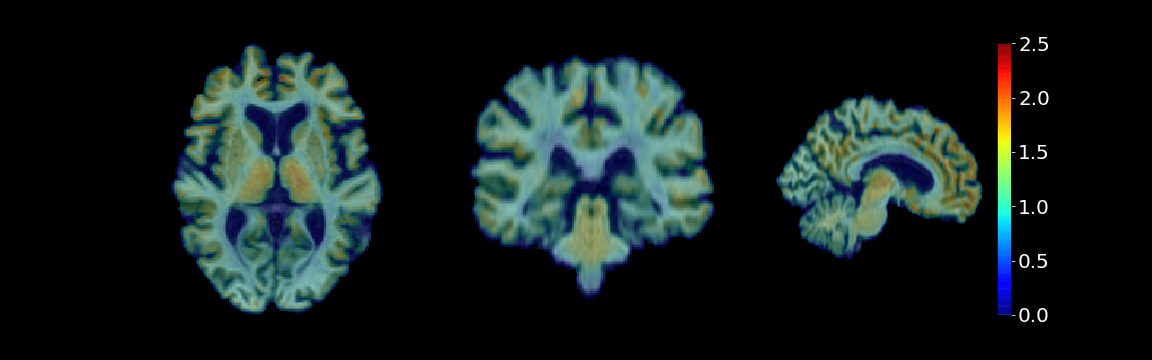

In [51]:
# DVR LRSC (PVC)
Image(filename=os.path.join(output_dir,'output','MNI_wf','QC',id_example,
                            id_example+'_pib_rbv_pvc_DVR_lrsc_mni_snap.png'))